In [11]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1239]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter, namedtuple
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce, partial
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# sys.path.insert(0, '/nas/xd/projects/transformers/src')
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.models.gpt_neo.modeling_gpt_neo import GPTNeoSelfAttention
from transformers.models.gptj.modeling_gptj import GPTJAttention, GPTJBlock
from transformers.models.xglm.modeling_xglm import XGLMAttention

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

In [13]:
import einops
from einops import rearrange

In [14]:
# from child_utils import *
from common_utils import *
from child_tasks import *
from model_utils import *

In [16]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [654]:
# model_name = "EleutherAI/gpt-neo-1.3B"
for model_name in ['gpt2-large', 
            'gpt2-xl', 'EleutherAI/gpt-neo-1.3B',  # = babbage
            'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', # = curie 
            'KoboldAI/fairseq-dense-13B']:
    if model_name not in models:
        with Timer(model_name):
            model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)  
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            models[model_name] = model, tokenizer

gpt2-xl ... done 0:02:54
EleutherAI/gpt-neo-1.3B ... 

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

done 0:02:21
EleutherAI/gpt-j-6B ... done 0:09:32
KoboldAI/fairseq-dense-6.7B ... done 0:05:13
KoboldAI/fairseq-dense-13B ... 

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

done 0:09:43


In [1371]:
# model_name = 'gpt2-large'  # medium / large /xl
model_name = 'EleutherAI/gpt-j-6B' # gpt-j-6B, gpt-neo-1.3B/2.7B
model, tokenizer = models[model_name]
_ = model.eval()

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<extra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [1252]:
models.keys()

dict_keys(['gpt2-large', 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B', 'text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'])

In [1673]:
unify(model)
blocks = model.transformer.h
attn = blocks[0].attn
L, H, embed_dim = len(blocks), attn.num_heads, attn.embed_dim

we = model.transformer.wte.weight.data.t()
# wp = model.transformer.wpe.weight.t()
wu = model.lm_head.weight.data

In [17]:
# k, n = 5, 4
# bos_id, eos_id = tokenizer._convert_token_to_id('Ġ->'), tokenizer._convert_token_to_id('Ċ')
# l = [bos_id] + choices(range(1, tokenizer.vocab_size-1), k=k) + [eos_id]
# text = tokenizer.decode(l * n)
# examples = text.strip().split('\n')
# print(text)

 -> Lawyers round Wyratesitors
 -> Lawyers round Wyratesitors
 -> Lawyers round Wyratesitors
 -> Lawyers round Wyratesitors



In [1241]:
def forward(model, inputs, labels=None, loss_reduction='None', by_head=False, attribute_layer=None, 
            head_mask=None, mlp_mask=None, attn_weights=None,
            hidden_states=None, detach_layer=None, 
            separate_qkv_layer=None, get_hqkv=None):
    head_mask = fill_list(head_mask, L, attribute_layer)
    mlp_mask = fill_list(mlp_mask, L, attribute_layer)
    attn_weights = fill_list(attn_weights, L, attribute_layer)
    # get_hqkv_fns = fill_list(get_hqkv, L, separate_qkv_layer, default_get_hqkv)
    from_layer = attribute_layer if hidden_states is not None else None

    self = model.transformer
    (hidden_states, inputs_embeds, position_embeds) = embed_forward(self, inputs) \
        if from_layer is None else (hidden_states, None, None)
    all_hidden_states, intermediates, mlp_outputs = (), (), ()
    attn_forward_outputs = []
    for i, b in enumerate(self.h):
        if from_layer is not None and i < from_layer: continue
        if i == detach_layer: hidden_states = hidden_states.detach()
        all_hidden_states += (hidden_states,)
        # hq, hk, hv = get_hqkv_fns[i](hidden_states)
        hq = hk = hv = b.ln_1(hidden_states)
        attn_forward_output = attn_forward(b, hq, hk, hv, by_head=by_head,
                                    head_mask=head_mask[i], attn_weights=attn_weights[i])
        attn_forward_outputs.append(attn_forward_output)
        if not my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
        mlp_output, intermediate = mlp_forward(b, hidden_states, output_intermediate=True)
        if mlp_mask[i] is not None: mlp_output = einsum('bie,bi->bie', mlp_output, mlp_mask[i])
        intermediates += (intermediate,)
        mlp_outputs += (mlp_output,)
        if my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
        hidden_states = hidden_states + mlp_output
    attn_outputs, all_attentions, head_inputs, head_outputs = zip(*attn_forward_outputs)
    all_hidden_states += (hidden_states,) # both before and after ln_f
    hidden_states = self.ln_f(hidden_states)
    all_hidden_states += (hidden_states,)

    logits = model.lm_head(hidden_states)
    loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
    return Outputs(
        inputs_embeds=inputs_embeds, position_embeds=position_embeds,
        attn_outputs=attn_outputs, head_inputs=head_inputs, head_outputs=head_outputs, 
        intermediates=intermediates, mlp_outputs=mlp_outputs,
        hidden_states=all_hidden_states, attentions=all_attentions, 
        logits=logits, loss=loss,
    )

In [ ]:
# nrows, ncols = 2, 3
# text, examples = make_input_str(tasks[0], nrows=nrows, ncols=ncols)
text = "\u003CInduction example. Goobledegook. Goobledegook"  # from unseal
bos_token, eos_token = '.', None
examples = text.split(bos_token)[1:]
k_shot = 1
print(text)
inputs = tokenizer.encode_plus(text, return_tensors='pt')
inputs = prepare_inputs(inputs, model.device)
input_ids = inputs.input_ids
qlen = input_ids.size(1)
# tokenize without tokenization artifact -> needed for visualization, from unseal
tokens = tokenizer.tokenize(text)
tokens = list(map(tokenizer.convert_tokens_to_string, map(lambda x: [x], tokens))) 

In [1649]:
# bos_indices, eos_indices, answers, labels = locate_answers(input_ids, tokenizer, bos_token=bos_token, eos_token=eos_token)
# labels[:, :bos_indices[k_shot]] = -100
# with torch.no_grad(): o0 = model(**inputs, output_attentions=True, output_hidden_states=True)
# with torch.no_grad(): o = forward(model, inputs, labels=labels, by_head=True)
with torch.no_grad(): so = sum_forward(model, o, labels=labels, ln_scale=0.2)

In [1651]:
loss, _ = show_predictions(text, examples, tokenizer, so.logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
print(loss)

* four 0.797 {' four': 0.797, ' 4': 0.088, ' five': 0.024} 	 three -> four
* fourth 0.845 {' fourth': 0.845, ' four': 0.051, ' first': 0.033} 	 third -> fourth
* Saturday 0.897 {' Saturday': 0.897, ' Monday': 0.055, ' Sunday': 0.018} 	 Friday -> Saturday
* Sunday 0.987 {' Sunday': 0.987, ' Monday': 0.009, ' Saturday': 0.001} 	 Saturday -> Sunday
* r 0.228 {' r': 0.228, ' w': 0.2, ' a': 0.169} 	 q -> r
* six 0.925 {' six': 0.925, ' seven': 0.017, ' 6': 0.015} 	 five -> six
* eighth 0.716 {' eighth': 0.716, ' eight': 0.215, ' e': 0.036} 	 seventh -> eighth
* eight 0.788 {' eight': 0.788, ' eighth': 0.086, ' nine': 0.07} 	 seven -> eight
* March 0.947 {' March': 0.947, ' January': 0.014, ' February': 0.012} 	 February -> March
* Thursday 0.989 {' Thursday': 0.989, ' Friday': 0.003, ' Tuesday': 0.001} 	 Wednesday -> Thursday
* May 0.948 {' May': 0.948, ' June': 0.026, ' August': 0.006} 	 April -> May
tensor(0.2514)


In [ ]:
layer_out = L
ln_f = model.transformer.ln_f
for i in range(0, L + 1):
    h = o.hidden_states[i]
    # h = h + attn_forward(blocks[-2], h, h, h)[0]
    # h = h + mlp_forward(blocks[-2], h)
    # h = h + attn_forward(blocks[-1], h, h, h)[0]
    # h = h + mlp_forward(blocks[-1], h)
    # h = ln_f(h)
    # logits = model.lm_head(ln_f(h))
    # print(i)
    # _, all_top1_correct = show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
    #             mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')

    logits = model.lm_head(ln_f(h + o.attn_outputs[i]))
    print(i, 'after attn')
    _, all_top1_correct = show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')
    logits = model.lm_head(ln_f(h + o.attn_outputs[i] + o.mlp_outputs[i]))
    print(i, 'after mlp')
    _, all_top1_correct = show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')
    if all_top1_correct and layer_out == L: layer_out = i
print(layer_out)

In [1758]:
models.keys()

dict_keys(['gpt2-large', 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B', 'text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'])

In [1824]:
logits = head_forward(model, o.hidden_states[0], layer, head, 
        labels=labels, loss_reduction='mean', attn_weights=o.attentions[layer]).logits
show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
        mask_logits_fn=None, topk=4, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')

  four 0.0 {'November': 0.147, '31': 0.088, ' them': 0.074, '41': 0.05} 	 three -> four
  fourth 0.0 {'November': 0.225, 'Nov': 0.123, '2001': 0.067, ' Nov': 0.06} 	 third -> fourth
  Saturday 0.0 {'November': 0.13, 'Nov': 0.103, ' them': 0.103, '2001': 0.062} 	 Friday -> Saturday
  Sunday 0.0 {'November': 0.108, 'Nov': 0.105, ' Nov': 0.047, 'Dec': 0.045} 	 Saturday -> Sunday
  r 0.0 {'November': 0.211, '31': 0.126, 'Nov': 0.062, ' them': 0.058} 	 q -> r
  six 0.0 {'2001': 0.282, 'November': 0.098, '31': 0.074, ' them': 0.045} 	 five -> six
  eighth 0.0 {'Nov': 0.143, '1970': 0.08, 'November': 0.076, '2001': 0.06} 	 seventh -> eighth
  eight 0.0 {'2001': 0.161, 'November': 0.151, 'Nov': 0.089, ' Nov': 0.082} 	 seven -> eight
  March 0.0 {'31': 0.201, ' them': 0.141, 'November': 0.126, '41': 0.045} 	 February -> March
  Thursday 0.0 {'Nov': 0.111, '31': 0.093, 'November': 0.092, ' them': 0.086} 	 Wednesday -> Thursday
  May 0.0 {'31': 0.485, 'November': 0.055, '41': 0.027, '2001': 0.026

(tensor(12.6798, grad_fn=<NllLossBackward>), False)

In [1805]:
for l, h, v in zip(*topk_md(head_attr, 2)):
    print(l, h, v)
    # logits = model.lm_head(o.head_outputs[l][:, h])
    # logits = model.lm_head(ln_f(o.head_outputs[l][:, h]))
    logits = model.lm_head(scaled_ln(ln_f, o.head_outputs[l][:, h]))
    show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=4, loss_reduction='argmax', show_range=range(k_shot, len(examples)), sep='\t')

18 3 1.4756324
* four 0.804 {' four': 0.804, ' three': 0.17, ' five': 0.011, 'three': 0.009} 	 three -> four
* fourth 0.937 {' fourth': 0.937, ' third': 0.063, ' fifth': 0.0, 'fourth': 0.0} 	 third -> fourth
  Saturday 0.036 {' Friday': 0.599, 'Friday': 0.145, 'Saturday': 0.055, ' Thursday': 0.055} 	 Friday -> Saturday
  Sunday 0.022 {'Saturday': 0.376, ' Saturday': 0.354, ' Monday': 0.109, ' Friday': 0.083} 	 Saturday -> Sunday
  r 0.0 {' four': 0.494, ' fourth': 0.384, ' three': 0.057, 'four': 0.032} 	 q -> r
  six 0.0 {' five': 0.998, 'five': 0.002, ' Five': 0.0, ' six': 0.0} 	 five -> six
  eighth 0.032 {' seventh': 0.966, ' eighth': 0.032, ' sixth': 0.001, ' ninth': 0.0} 	 seventh -> eighth
  eight 0.0 {' seventh': 0.878, ' eighth': 0.122, ' sixth': 0.0, ' ninth': 0.0} 	 seven -> eight
  March 0.0 {' seventh': 0.841, ' eighth': 0.158, ' sixth': 0.0, ' ninth': 0.0} 	 February -> March
  Thursday 0.045 {'Wednesday': 0.581, ' Wednesday': 0.249, 'Thursday': 0.094, ' Thursday': 0.045} 

(tensor([0.4101], grad_fn=<DivBackward0>), False)

14 13 0.62621903
  four 0.0 {' 2004': 0.584, '2004': 0.24, ' 4': 0.097, ' 04': 0.043} 	 three -> four
  fourth 0.002 {' 2004': 0.715, ' 4': 0.132, '2004': 0.098, ' 04': 0.027} 	 third -> fourth
* Saturday 0.537 {' Saturday': 0.537, 'Saturday': 0.438, ' weekend': 0.024, ' Weekend': 0.0} 	 Friday -> Saturday
* Sunday 0.738 {' Sunday': 0.738, 'Sunday': 0.262, ' Sundays': 0.0, ' 1982': 0.0} 	 Saturday -> Sunday
  r 0.0 {'1990': 0.494, ' 1990': 0.383, '1995': 0.038, '90': 0.028} 	 q -> r
  six 0.0 {'6': 0.443, ' 6': 0.268, ' 2006': 0.239, ' sixth': 0.025} 	 five -> six
  eighth 0.075 {' 8': 0.516, '8': 0.38, ' eighth': 0.075, ' 08': 0.007} 	 seventh -> eighth
  eight 0.003 {' 8': 0.591, '8': 0.4, ' eighth': 0.003, ' eight': 0.003} 	 seven -> eight
* March 0.937 {' March': 0.937, 'March': 0.063, '03': 0.0, ' April': 0.0} 	 February -> March
* Thursday 0.815 {' Thursday': 0.815, 'Thursday': 0.175, ' 1999': 0.005, '1999': 0.003} 	 Wednesday -> Thursday
* May 0.966 {' May': 0.966, 'May': 0.034,

(tensor([0.4374], grad_fn=<DivBackward0>), False)

In [1679]:
layer, head = 14, 13  # 13, 9
wv, wo = get_head_weights(layer, head)[2:]
wov = wo @ wv
ln_1 = blocks[layer].ln_1

In [1681]:
def T(module): return lambda x: module(x.T).T

In [1684]:
n = 10000
with torch.no_grad(): eov = wu[:n] @ T(ln_f)(wov @ T(ln_1)(we[:, :n]))

In [1685]:
in_ids, out_ids, values = topk_md(eov.T, 20)

In [ ]:
tokenizer.convert_ids_to_tokens(eov.T[tokenizer.encode(' four')[0]].topk(10).indices)

In [1762]:
del sum_forward
from model_utils import sum_forward

In [1806]:
def head_forward(model, hidden_states, layer, head, labels=None, loss_reduction='per_example_mean', attn_weights=None):
    blocks = model.transformer.h
    ln_f = model.transformer.ln_f
    hq = hk = hv = scaled_ln(blocks[layer].ln_1, hidden_states)
    if attn_weights is not None: hq, hk = None, None
    head_output = attn_forward(blocks[layer], hq, hk, hv, by_head=True, attn_weights=attn_weights)[-1]
    logits = model.lm_head(scaled_ln(ln_f, head_output[:, head]))
    loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
    return Outputs(logits=logits, loss=loss)

In [ ]:
def head_forward(model, o, hidden_states, layer, head, labels=None, loss_reduction='per_example_mean', attn_weights=None, ln_scale=0.1):
    blocks = model.transformer.h
    ln_f = model.transformer.ln_f
    hq = scaled_ln(blocks[layer].ln_1, hidden_states, scale=ln_scale)
    hk = hv = blocks[layer].ln_1(o.hidden_states[layer])
    attn_weights = attn_forward(blocks[layer], hq, hk, hv)[1]  # bnij
    return attn_weights[:, head, i, j]
    # logits = model.lm_head(ln_f(head_output[:, head]))
    logits = model.lm_head(scaled_ln(ln_f, head_output[:, head], scale=0.1))
    # logits = model.lm_head(head_output[:, head])
    print('in head_forward, logits.std() = ', logits.std(dim=(1, 2)))
    loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
    return Outputs(logits=logits, loss=loss)

In [1808]:
keys = ['head_mask', 'mlp_mask', 'embed_mask'] # 对head_output归因，看哪些head重要（先运行，粗粒度）
# keys = ['attn_weights', 'mlp_mask', 'embed_mask']  # 对attn_weights归因，看哪些head的哪些关注重要（后运行，细粒度）
forward_fn = partial(sum_forward, outputs=o, labels=labels, ln_scale=0.1)
x = OrderedDict((key, get_x(key, o, to_layer=layer)) for key in keys)
# def get_y(outputs): return -outputs.loss
def get_y(outputs): 
    return -head_forward(model, outputs.hidden_states[0], layer, head, 
        labels=labels, loss_reduction='argmax', attn_weights=o.attentions[layer]).loss

attr, ys = attribute(forward_fn, x, get_y, num_points=10, batch_size=10)
print(ys)

tensor([-7.6859, -5.1056, -2.8403, -1.4931, -0.9759, -0.7459, -0.6134, -0.5319,
        -0.4774, -0.4374], grad_fn=<CatBackward>)


In [ ]:
# 对某层的attn_weights单独梯度归因
attrs = []
for attribute_layer in range(27):
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'head_mask': torch.ones(1, H, o.hidden_states[0].size(1))}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y, num_points=8)
    ys
    attrs.append(attr)
    
head_attr2 = rearrange([attr['head_mask'] for attr in attrs], 'l n i -> l n i')
head_attr2 = torch.einsum('lni->ln', head_attr2)
list(zip(*topk_md(head_attr2, 10)))

# 对某层的attn_weights单独梯度归因
for attribute_layer, attribute_head, __ in list(zip(*topk_md(head_attr, 10)))[:3]: # heads 27-17, 17-4, 22-13
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'attn_weights': o.attentions[attribute_layer]}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y)
    # ys
    print(attribute_layer, attribute_head)
    plot_attn(attr['attn_weights'][attribute_head], tokens, figsize=(5, 5))
    plt.show()

In [ ]:
attr['embed_mask'].size()

In [1815]:
torch.einsum('i->', attr['embed_mask'])

tensor(0.0161)

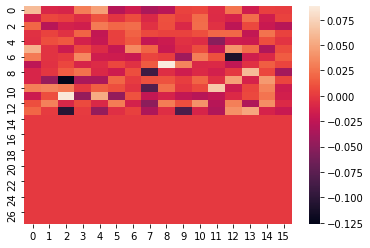

In [1809]:
head_attr = torch.einsum('lni->ln', attr['head_mask'])
_ = sns.heatmap(head_attr, cbar=True)

In [1810]:
list(zip(*topk_md(head_attr, 10)))

[(7, 8, 0.088101365),
 (11, 2, 0.085758075),
 (10, 11, 0.06878894),
 (8, 13, 0.060798533),
 (0, 0, 0.060572024),
 (5, 0, 0.057080515),
 (11, 4, 0.05267864),
 (13, 13, 0.0500323),
 (0, 4, 0.046680804),
 (9, 12, 0.04657458)]

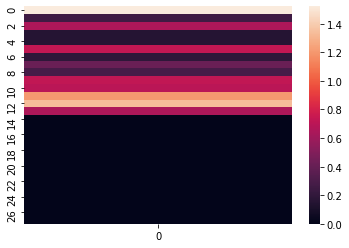

In [1811]:
mlp_attr = torch.einsum('li->l', attr['mlp_mask'])
_ = sns.heatmap(mlp_attr.unsqueeze(-1), cbar=True)

In [1812]:
list(zip(*topk_md(mlp_attr, 10)))

[(0, 1.5206398),
 (12, 1.3346266),
 (11, 1.2005539),
 (5, 0.72985584),
 (9, 0.71945673),
 (10, 0.6952129),
 (2, 0.65090084),
 (13, 0.6501601),
 (7, 0.41141868),
 (8, 0.28354797)]

18 3 1.4756324


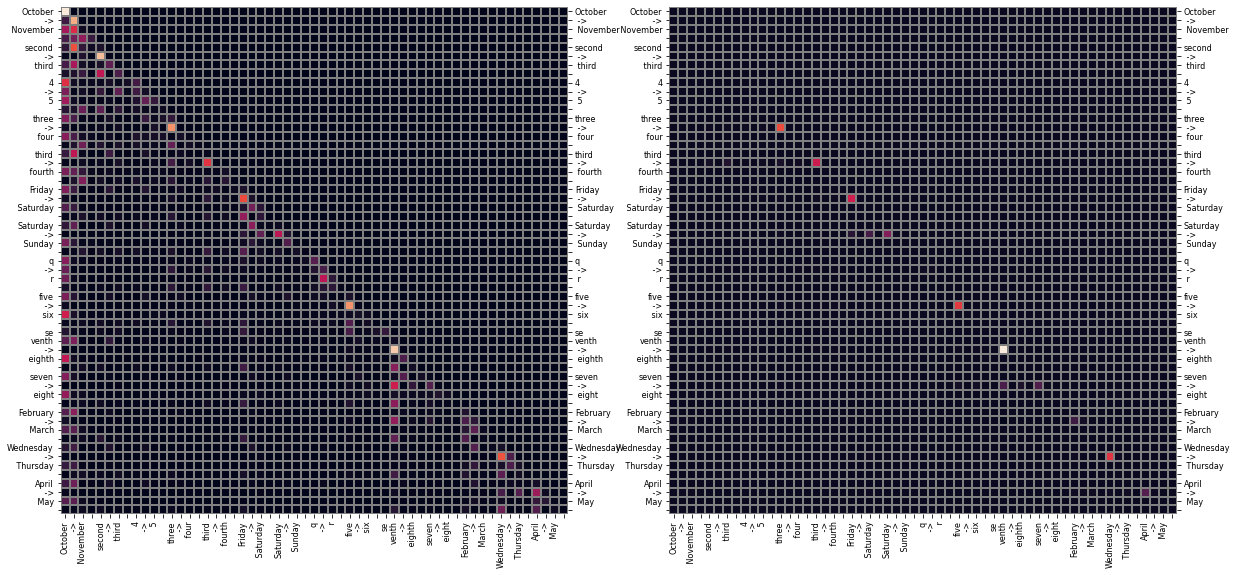

14 13 0.62621903


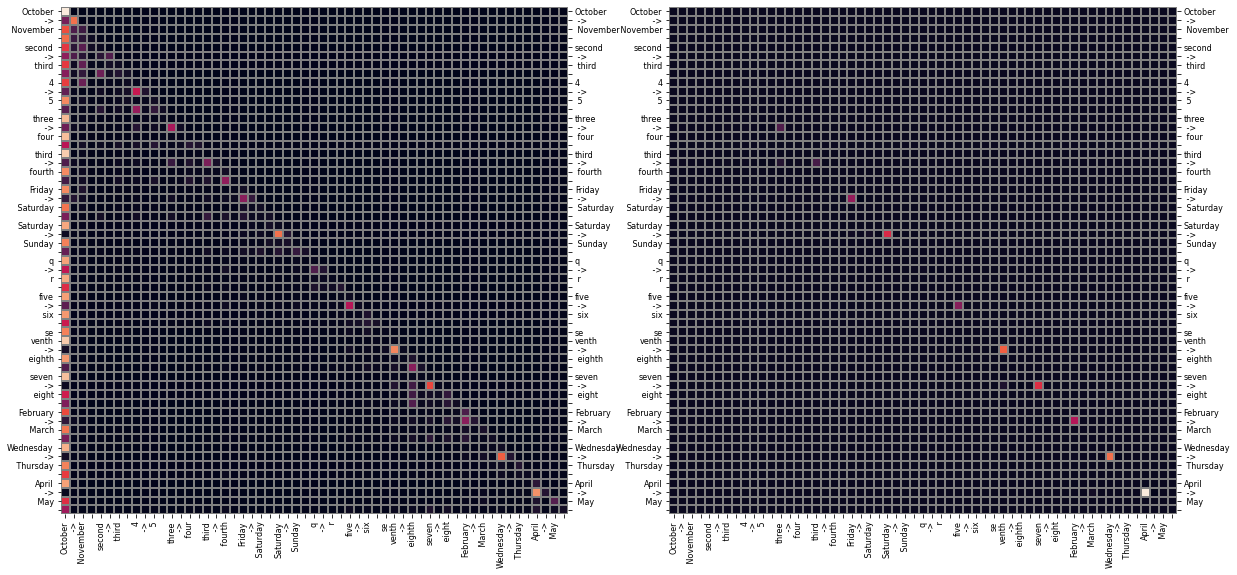

16 10 0.5341668


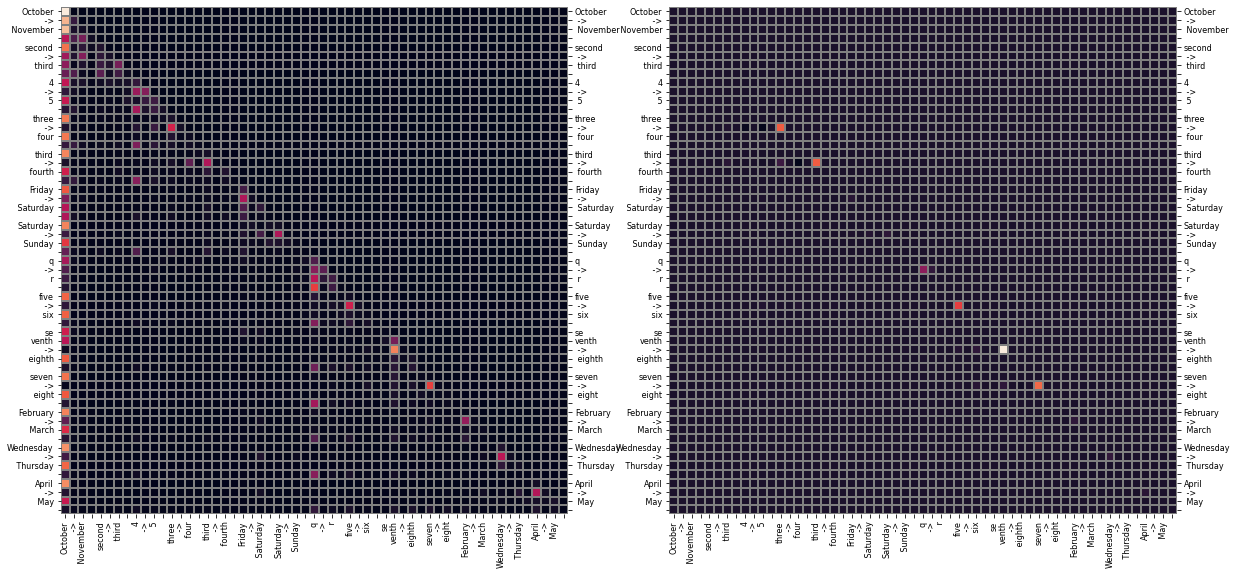

24 10 0.5313083


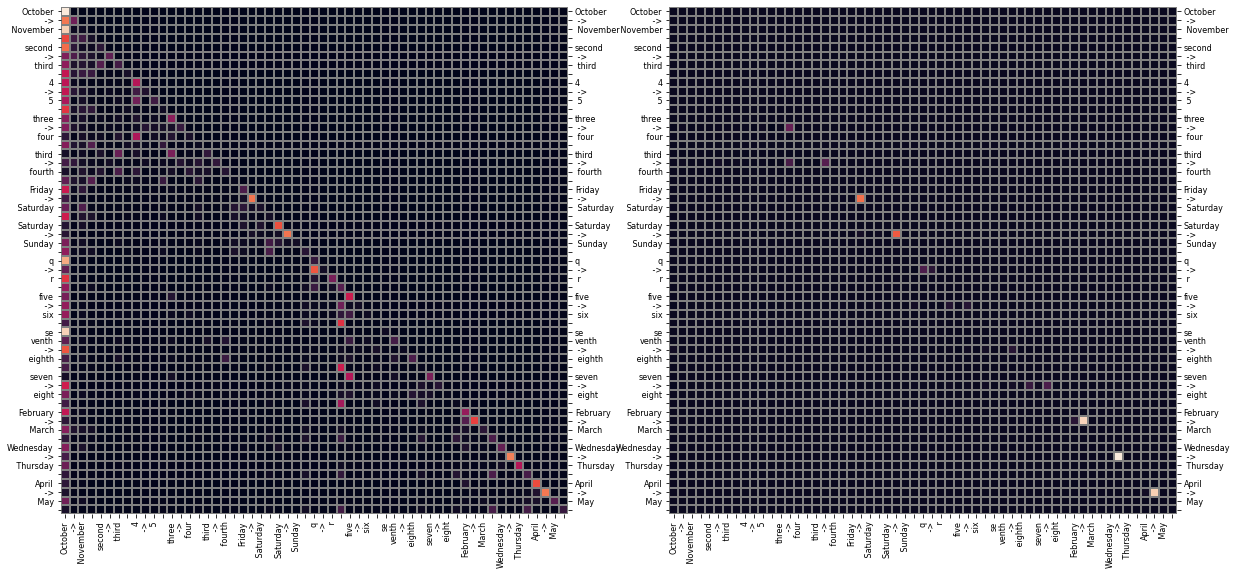

13 4 0.49990296


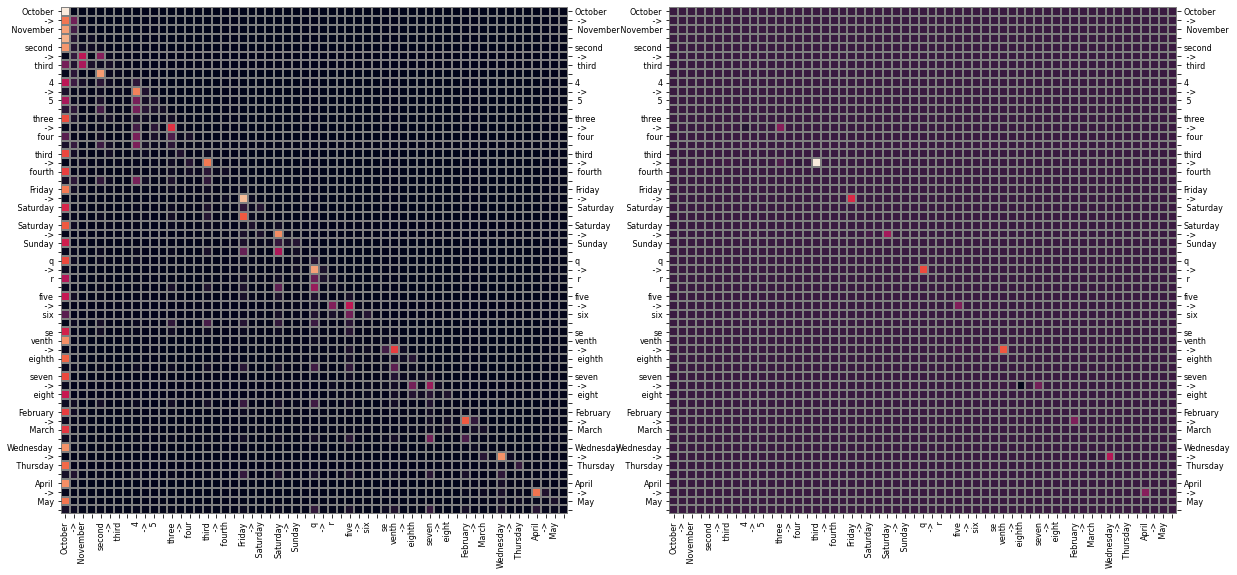

9 2 0.48765278


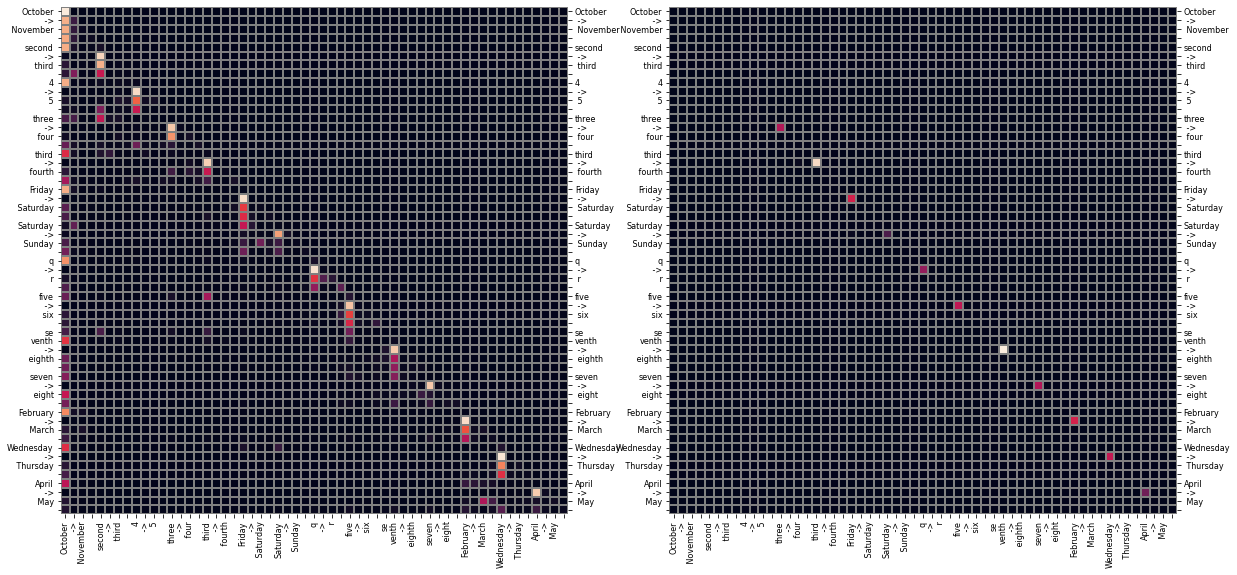

17 10 0.4534232


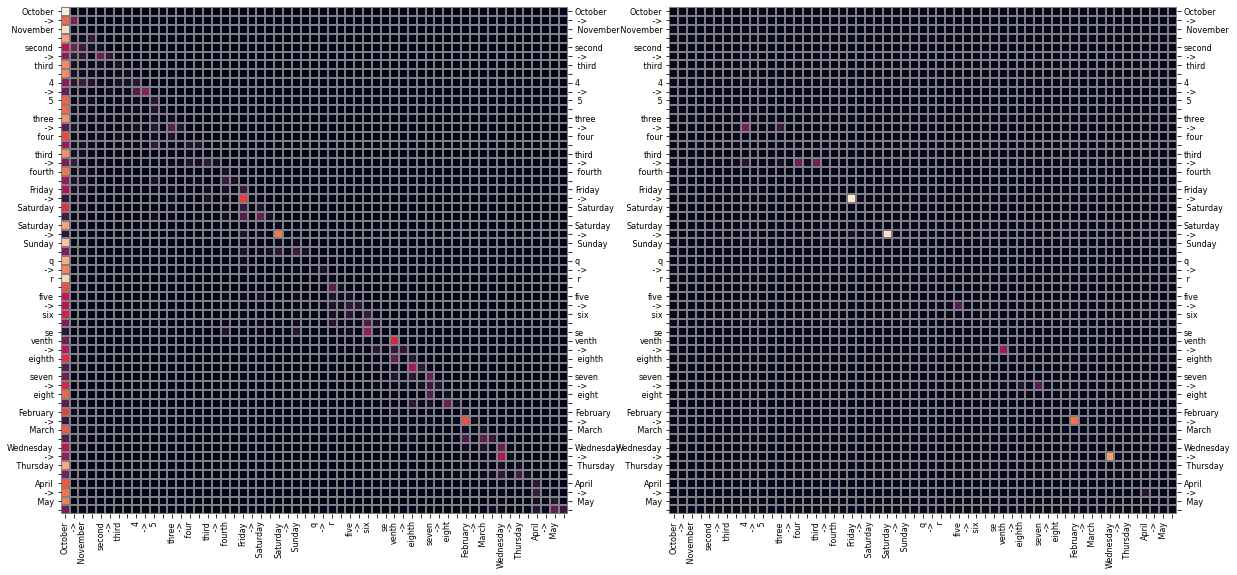

13 13 0.36967224


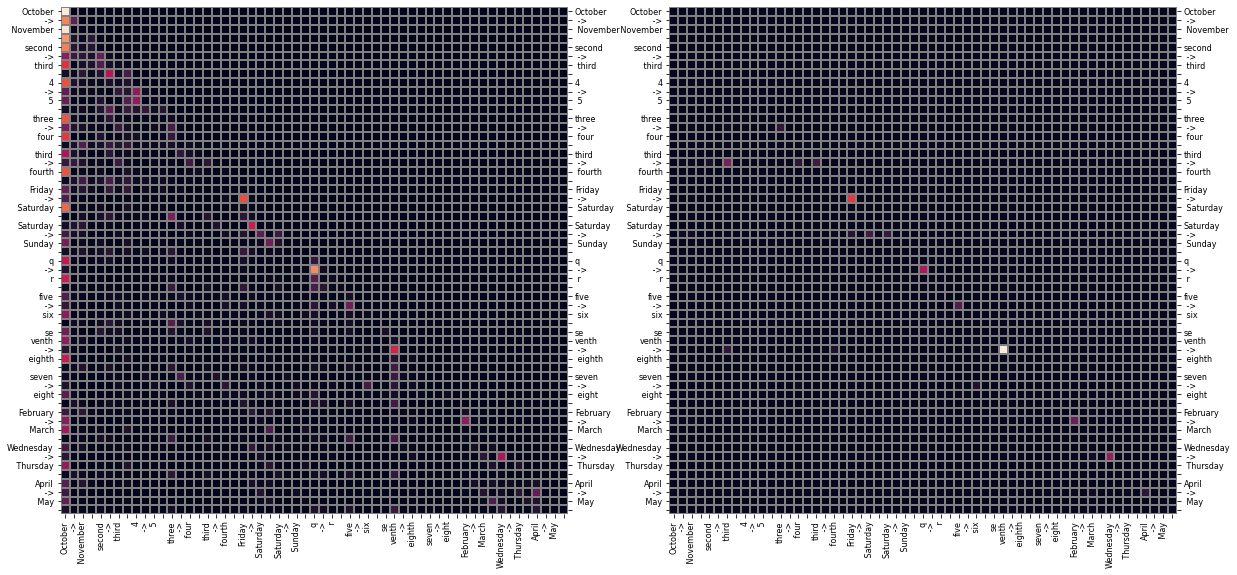

14 7 0.2718836


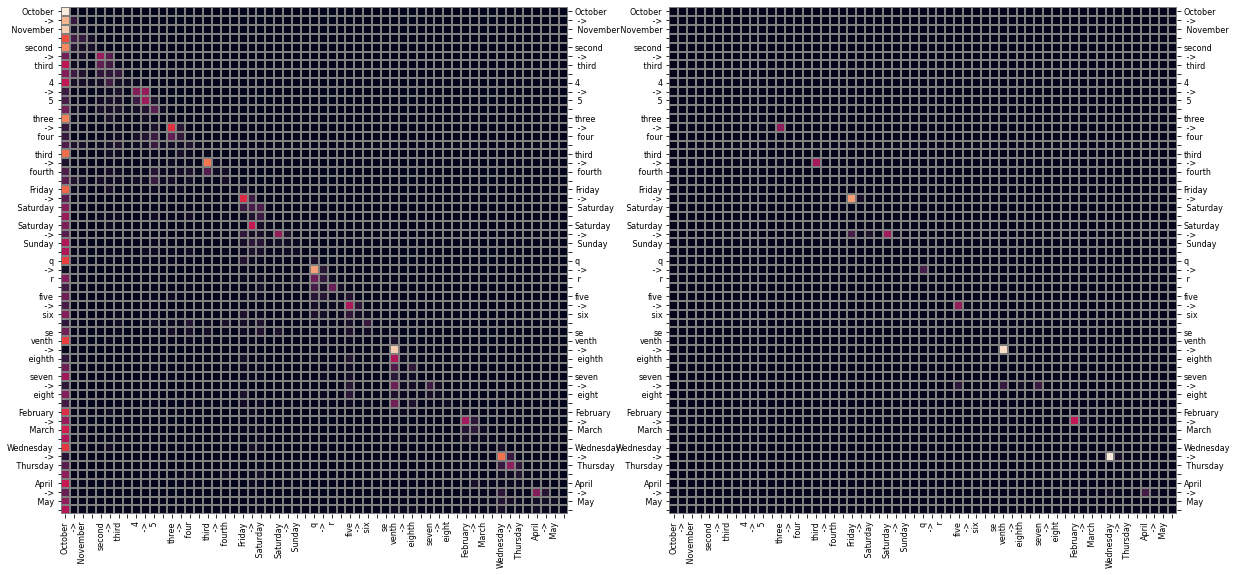

22 7 0.26868737


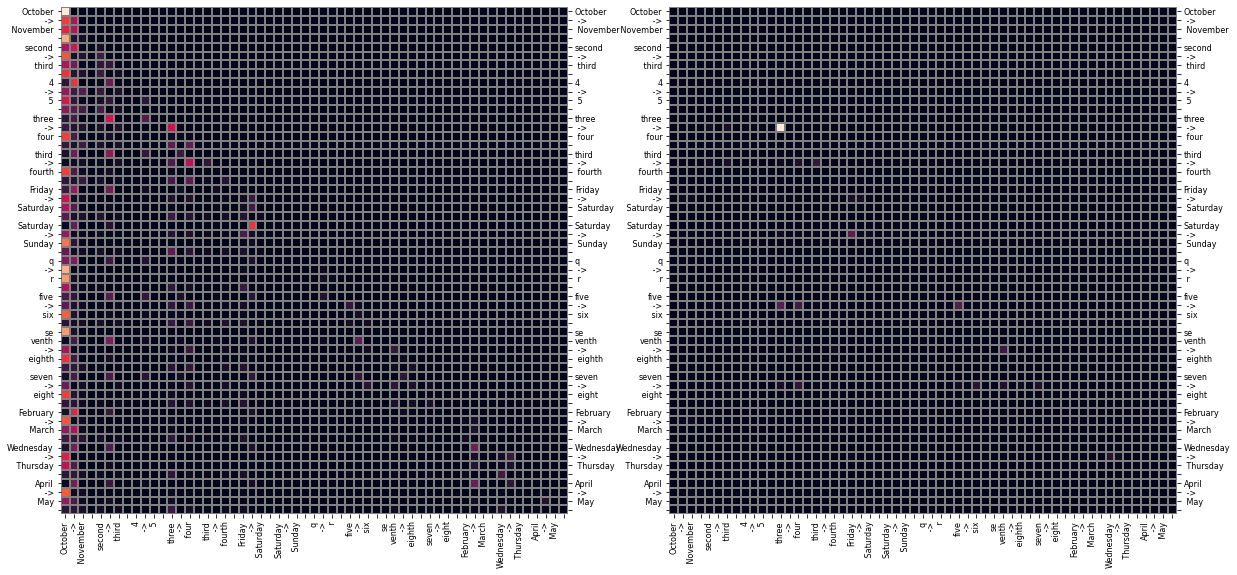

In [1656]:
# 对attn_weights归因后运行
attn_attr = attr['attn_weights']
attentions = torch.cat(o.attentions)

for l, h, v in zip(*topk_md(head_attr, 10)):
    # if (l, h) not in [(13, 9), (16, 14), (13, 2)]: continue
    print(l, h, v)
    # fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    # for ax, a in zip(axs, [attentions[l, h], attn_attr[l, h], binarize(attn_attr[l, h])]):
    #     plot_attn(a, tokens, ax=ax)
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
    for ax, a in zip(axs, [attentions[l, h], attn_attr[l, h]]):#, binarize(attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

以上用归因找到对最终预测结果起重要作用的上层heads（induction heads），  
以下用归因找到对上层induction heads的attn_weights起重要作用的下层heads（Q-compostion or K-composition with induction heads）

In [72]:
# 找第2重要的induction head（17-4）的K-composition heads
layer, head, _ = list(zip(*topk_md(head_attr, 10)))[1]
layer, head
aw_label = binarize(attn_attr[layer, head])
wq, wk = get_head_weights(layer, head)[:2]

(17, 4)

In [73]:
# 对head_output归因
query = torch.einsum('bie,de->bid', o.hidden_states[layer], wq)
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
key = torch.einsum('blnje,de->blnjd', head_outputs, wk)
attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

In [ ]:
_ = sns.heatmap(attn_head_attr)
list(zip(*topk_md(attn_head_attr, 10)))

In [ ]:
d e q -> e
8 p v -> p
i 6 o -> 6

In [80]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
if True: # faster version
    key = head_inputs_ @ wk.T  # lnje,de->lnjd
    lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
    lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, j_attn_logits)
else: # slower version, but easier to understand (similar to unseal)
    lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
    key = lnije @ wk.T  # lnije,de->lnijd    
    lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)

In [ ]:
for l, h, v in zip(*topk_md(attn_head_attr, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

In [473]:
all_attrs, all_yss = {}, {}

In [324]:
def qk_forward(model, outputs, layer, head, aw_label, attr_x, **mask_kwarges):
    ln = blocks[layer].ln_1
    kwargs = {x: ln(outputs.hidden_states[layer]) for x in ['hq', 'hk', 'hv']}
    kwargs[attr_x] = scaled_ln(ln, sum_forward(model, outputs, **mask_kwarges).hidden_states[0], scale=0.01) # attr_x in ['hq', 'hk']
    aw = attn_forward(blocks[layer], **kwargs)[1][:, head]
    aw_label_sum = torch.einsum('ij->', aw_label)
    # print('aw_label_sum =', aw_label_sum)
    mean_prob = torch.einsum('bij,ij->b', aw, aw_label) / aw_label_sum
    mean_logprob = torch.einsum('bij,ij->b', (aw + 1e-8).log(), aw_label) / aw_label_sum
    print('mean_prob =', mean_prob)
    print('mean_logprob =', mean_logprob)
    return mean_prob, mean_logprob

In [ ]:
# ig attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y)
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
attrs, yss = all_attrs[key], all_yss[key]

In [ ]:
dlosses = [(ys[0] - ys[-1]).item() for ys in yss]
np.array(dlosses)
_ = plt.bar(range(len(dlosses)), dlosses, 0.3)

In [248]:
# nattrs = [attr / abs(dloss) for attr, dloss in zip(attrs, dlosses)]
nattrs = [attr / attr.abs().mean() for attr in attrs]

In [251]:
mean_nattrs = torch.cat([nattr.mean(dim=-1) for nattr in nattrs])

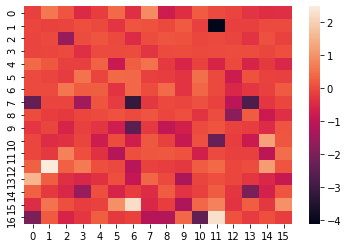

In [252]:
_ = sns.heatmap(mean_nattrs, cbar=True)

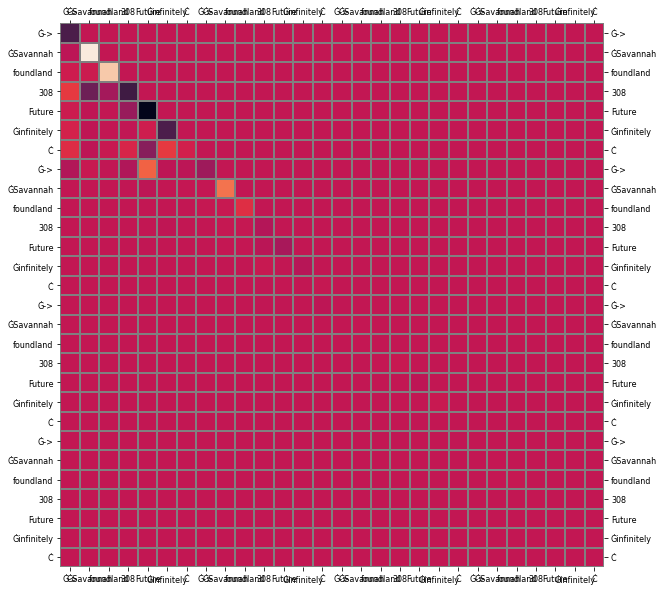

In [320]:
l, h = 6, 6
# attn = o.attentions[l][0, h]
attn = attrs[l][0, h]
plot_attn(attn, tokens)

QK circuit: $W_E^T W_Q^T W_K W_E$  
OV circuit: $W_U W_O W_V W_E$

In [230]:
def plot_eigenvalues(evs, ncols=4):
    fig, axs = plt.subplots(H // ncols, ncols, sharex=True, sharey=True, figsize=(20, 5))
    for i, (e, v) in enumerate(evs):
        e = e.detach().numpy()
        _ = axs[i // ncols][i % ncols].plot(e[:,0], e[:,1], '.')

In [281]:
WQK, WOV = [], []
for l in tqdm(range(L)):
    WQK.append([combine_weights(get_head_weights(l, h), qk=True) for h in range(H)])
    WOV.append([combine_weights(get_head_weights(l, h), qk=False) for h in range(H)])

100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


In [284]:
WQK = [[combine_weights(get_head_weights(l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]

100%|██████████| 24/24 [00:01<00:00, 20.26it/s]


In [333]:
# rwqk2, rwov1 = torch.rand(hidden_size, hidden_size) * 10, torch.rand(hidden_size, hidden_size) * 100

# rwq, rwk = torch.rand(hidden_size // H, hidden_size)*10, torch.rand(hidden_size // H, hidden_size)
# rwo, rwv = torch.rand(hidden_size, hidden_size // H), torch.rand(hidden_size // H, hidden_size)*100
# rwqk2, rwov1 = rwq.t().mm(rwk), rwo.mm(rwv)

# rwqk2.mm(rwov1).norm() / (rwqk2.norm() * rwov1.norm())

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio: $||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

In [345]:
dl = 3
kcomp3 = np.array([[[(WQK[l][h2].mm(WOV[l-dl][h1]).norm() / (WQK[l][h2].norm() * WOV[l-dl][h1].norm())).item() 
          for h1 in range(H)] for h2 in range(H)] for l in tqdm(range(dl, L))])

100%|██████████| 21/21 [01:23<00:00,  3.96s/it]


In [1703]:
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')

In [74]:
chains = [
    [(4, 14), (3, 3)],  # 0.24024388
    [(5, 4), (2, 2)],  # 0.21996385
    [(5, 4), (3, 7)],  # 0.31488344
    [(6, 6), (3, 3)],  # 0.27304175
    [(6, 6), (5, 3)],  # 0.12567882
]

In [314]:
(l2, h2), (l1, h1) = chains[4]

In [433]:
e = WQK[l2][h2].mm(WOV[l1][h1]).eig()[0]

In [435]:
e[:10] = 0

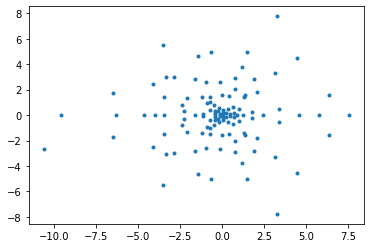

In [436]:
scatter_plot(e)

In [437]:
e = WOV[l2][h2].eig()[0]

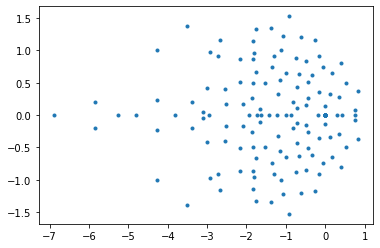

In [438]:
scatter_plot(e)

In [356]:
a = kcomp3[2]; ind = np.unravel_index(a.argmax(), a.shape); ind, a[ind]

((4, 2), 0.21996384859085083)

<AxesSubplot:>

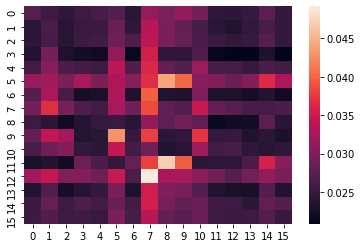

In [319]:
kcomp = np.array(kcomp)
sns.heatmap(kcomp, cbar=True)

In [364]:
wov_evs = [torch.eig(combine_weights(get_head_weights(3, h), qk=False, with_embedding=True, BA=True)) for h in tqdm(range(H))]

100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


  0%|          | 0/16 [3:32:06<?, ?it/s]


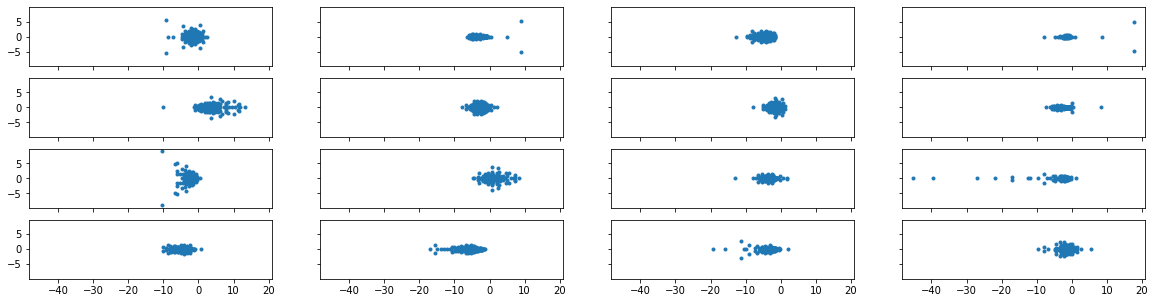

In [363]:
plot_eigenvalues(wov_evs)

In [138]:
w_eu = w_e.matmul(w_u)

In [522]:
def mlp(layer): return lambda x: blocks[layer].mlp(blocks[layer].ln_2(x))
def mlp0(layer): return lambda x: blocks[layer].mlp(x)

In [186]:
def attn(layer): return lambda x: blocks[layer].attn(blocks[layer].ln_1(x))

In [537]:
w_e2 = w_e * 50
w_eu2 = (w_e2 + mlp0(L-1)(w_e2)).matmul(w_u)

In [ ]:
# grad attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y);
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
plot_attn(globalize(attentions[8])[0, 2], figsize=(20, 20))

In [5395]:
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print('%2d %s' %(i, token), end='  ')
tgt_positions


 1 E   2 N   3 K   4 R   5 ->   6 N  
 8 A   9 T  10 D  11 7  12 ->  13 T  
15 Q  16 A  17 P  18 K  19 ->  20 A  
22 A  23 N  24 L  25 5  26 ->  27 N  
29 V  30 1  31 P  32 B  33 ->  34 1  
36 G  37 V  38 7  39 4  40 ->  41 V  
43 R  44 Y  45 J  46 P  47 ->  48 Y  
50 A  51 C  52 S  53 Y  54 ->  55 C  


tensor([ 2,  9, 16, 23, 30, 37, 44, 51])

In [5409]:
a = all_attrs[task_name]['aw' + str(int(pred_attn))]
a = a / a.view(a.size(0), -1).norm(dim=1)[:, None, None, None] #.view(a.size(0), 1, 1, 1)
if not pred_attn:
    src_indices, tgt_indices = [src], [tgt]
    _a = a[:, :, src_indices, tgt_indices]
    values, indices = _a.view(_a.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices, src_indices=src_indices, tgt_indices=tgt_indices)
    print()
# src_indices = numpy(ans_positions[:])
# src_indices = numpy(tgt_positions + 1)
# tgt_indices = tgt_positions
_a = a[:, :, src_indices, :]
values, indices = _a.view(_a.size(0), H, -1).topk(nrows // 2, dim=-1)
show_top_heads(values, indices, src_indices=src_indices)#, tgt_indices=tgt_indices)

16-15	0.918 [(51, 0.918, 66.8)]	0.13030353 *0.66812056 0.011132528 0.0006797812 
14-0	0.783 [(51, 0.783, 66.5)]	0.14255618 *0.6645065 0.019694159 0.0019851688 
17-13	0.705 [(51, 0.705, 49.8)]	0.18755053 *0.49829417 0.078217894 0.10344336 
13-2	0.505 [(51, 0.505, 44.5)]	0.43078056 *0.44530356 0.017190581 0.001503151 
17-17	0.213 [(51, 0.213, 40.9)]	0.16368316 *0.4086181 0.24944614 0.11208218 
14-13	0.192 [(51, 0.192, 32.8)]	0.20337617 *0.32792574 0.07777147 0.073093265 
15-8	0.159 [(51, 0.159, 22.5)]	0.15539594 *0.22527154 0.26876858 0.27620015 
14-16	0.101 [(51, 0.101, 26.3)]	0.11579089 *0.2628595 0.104256935 0.014017421 
15-16	0.099 [(51, 0.099, 13.2)]	0.13631786 *0.1315605 0.098822616 0.30740336 
13-12	0.095 [(51, 0.095, 13.1)]	0.44031265 *0.13147357 0.035518978 0.05850061 
13-3	0.078 [(51, 0.078, 34.5)]	0.46285912 *0.34470326 0.08684665 0.0354087 
7-2	0.062 [(51, 0.062, 27.9)]	0.105706446 *0.2786354 0.16776893 0.2326701 
17-1	0.047 [(51, 0.047, 46.0)]	0.38024765 *0.45963302 0.023335

In [5408]:
def show_top_heads(values, indices, src_indices=None, tgt_indices=None, topk=15):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    for (l, h), v in zip(ind, val):
        _l = l + layer_range[0]
        if _l <= 3: continue
        top_links = list(zip(unravel_index(indices[l, h], (seq_len, seq_len)), numpy(values[l, h], decimals=3)))
        if src_indices is not None: top_links = [([src_indices[_s], _t], _v) for [_s, _t], _v in top_links]
        if tgt_indices is not None: top_links = [([_s, tgt_indices[_t]], _v) for [_s, _t], _v in top_links]
        top_links = [([_s, _t], _v, numpy(globalize(attentions[_l]) * 100, decimals=1)[0, h, _s, _t]) for [_s, _t], _v in top_links]
        _top_links = [([_s, _t], _v, _a) if len(src_indices) > 1 else (_t, _v, _a) for [_s, _t], _v, _a in top_links]
        print('%d-%d\t%.3f' % (_l, h, v), _top_links, end='\t') 
        if len(top_links) == 1:
            probs = numpy(globalize(attentions[_l])[0, h, src])
            for i in cand_range:
                if i == tgt: print('*', end='')
                print(probs[i], end=' ')
        print()

tensor([0.6156])


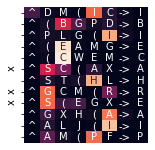

In [5057]:
a = globalize(attentions[layer2])[:, head2]
# a = a.softmax(-1)
a = torch.cat([a[:, i - 1: i, i - ncols - 2: i + 1] for i in ans_positions], dim=1)
# a = a.softmax(-1)
loss = a.view(a.size(0), -1)[:, tgt_positions[1:]].mean(dim=1)
print(loss)
plot_tgt_attn(a[0])

In [3455]:
wvos = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(11, 8), (12, 18)]]
wqk = torch.matmul(*get_head_weights(13, 2)[:2])
ww = wvos[0].matmul(wvos[1]).matmul(wqk)

In [3735]:
ww.norm(dim=0).topk(40).indices

tensor([2484,   88,  578, 1781,  586,  408, 2054,  304,  824, 1675, 1772,  501,
        2456, 1019,  936, 2463, 2368,  340, 2418,  101, 1734,  687, 2159, 1060,
          20, 1838,  224, 1669, 1187,  870, 1585,  232,  281, 1474, 1729,  328,
        1860, 1174,  816, 1524])

In [3741]:
show_topk(*aw.view(-1).topk(20, largest=False), indices_fn=indices_fn)

{(578, 586): -0.0016085216,
 (578, 88): -0.0011706072,
 (936, 1782): -0.0011014504,
 (578, 501): -0.0009034774,
 (578, 114): -0.00086396607,
 (578, 1761): -0.00080681103,
 (578, 1067): -0.0007989705,
 (936, 814): -0.00079893926,
 (936, 405): -0.00076955673,
 (936, 336): -0.0007586547,
 (578, 2149): -0.00074234203,
 (578, 1666): -0.0007264766,
 (578, 408): -0.00071433355,
 (578, 1019): -0.00066249806,
 (936, 946): -0.00065255526,
 (2484, 1675): -0.00064498984,
 (578, 1675): -0.0006330121,
 (578, 1651): -0.00062471436,
 (936, 1445): -0.00062095723,
 (578, 289): -0.0006184878}

In [4065]:
wvos2 = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(9, 9), (10, 1), (12, 18)]]
ww2 = reduce(torch.matmul, wvos2 + [wqk])

In [5015]:
attn_output1, out = None, None
out_proj_w = self1.out_proj.weight.view(hidden_size, H, -1).permute(1, 2, 0).unsqueeze(0)
head_mask = torch.zeros(H, seq_len, seq_len)
head_mask[[18,]] = 1
# head_mask[:] = 1
attn1 = attentions[layer1]
_attn1, __attn1 = torch.zeros_like(attn1), torch.zeros_like(attn1)
for i in range(0, nrows):
    _attn1[:, :, arrow_positions[i], ans_positions[i]] = 1
    __attn1[:, :, arrow_positions[i], ans_positions[:i]] = 1 / i if i > 0 else 0
    
def ffn(layer, x): return blocks[layer].mlp(blocks[layer].ln_2(x))

def tgt_attn_loss(h1, attn1, key0, residual=None, attn_output_w=1, apply_softmax=True, temperature=10, 
                  positions=tgt_positions, plot=False, ax=None):
    def get_attn(attn_output):
        out = (residual if residual is not None else 0) + attn_output * attn_output_w
        if residual is not None: out = out + ffn(layer1, out)
        if residual is not None: out = ln2(out)
        query = out.matmul(wq2.t()).unsqueeze(2) # (bsz, nrows, d_head) -> (bsz, nrows, 1, d_head), ln2 is omissible
        key = key0.matmul(wk2.t()).view(bsz, nrows, ncols + 3, hidden_size // H)
        a = (query * key).sum(-1) # (bsz, nrows, ncols + 3)
        a[:, :, [-1]] = -1e9
        if apply_softmax: a = (a / temperature).softmax(-1)
        return a

    self1.w = attn1 * head_mask; attn_output1 = self1(h1)[0] - self1.out_proj.bias
    a = get_attn(attn_output1[:, arrow_positions])
    loss = a.view(a.size(0), -1)[:, positions]
    if plot:
#         a = a - a.min(dim=2, keepdim=True).values
        plot_tgt_attn(a[0], ax=ax)#; print(loss)
    return loss.mean()

residual = None or hidden_states[layer1][:, arrow_positions]

[0.7721180319786072, 0.9933991432189941, 0.9961371421813965]

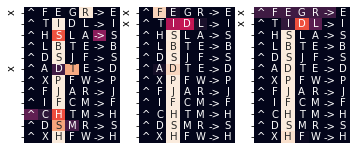

In [5052]:
def get_ln(layer): return blocks[layer].ln_1
# 10-ffn, 9-11 for find special, 9-11 for AbCD->B/b, 9-11 for ABCD->C
# 10-19+ffn+8!, 9-11 for after bracket 5-5/7, 9-11, 10-1+13+ffn+8+19 for in brackets
mask = torch.zeros(H, seq_len, 1); mask[11] = 1#; mask[:] = 0 # 11-8, 10-1, 9-11,   9-11/6?->8-17 for 2nd
# for i in range(0, nrows): mask[1, ans_positions[i], tgt_positions[i]+1] = 1
layer0 = 9
self0, ln0 = get_attn_module(blocks[layer0]), blocks[layer0].ln_1

h0 = hidden_states[9]*0 + head_outputs[8][:, [17]].sum(1)*1
self0.w = attentions[layer0] * mask; attn_output0 = self0((h0), attention_masks[layer0])[0] - self0.out_proj.bias
# h1 = hidden_states[9]*0 + head_outputs[11][:, [8]].sum(1)*1 #+ ffn_outputs[10]#+ head_outputs[11][:, [8,]].sum(1)*1
# h1 = ln1(h1)
h1 = attn_output0
key0 = get_ln(10)(hidden_states[10])#; key0.reqires_grad = True; key0.retain_grad()
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24))
# loss = tgt_attn_loss(h1, __attn1, key0, residual=None, plot=True, apply_softmax=True, temperature=1, ax=axes[0]); loss
# print('after', key0[:, :, 0])
[tgt_attn_loss(h1, attn, key0, residual=None,plot=True,temperature=1, positions=tgt_positions[(i>0)*2:],ax=ax).item() 
    for i, (attn, ax) in enumerate(zip([_attn1, attn1, __attn1], axes))]
# if losses[0] > 0.8 and losses[-1] > 0.8: print(layer, head, losses)

In [5075]:
def get_weight_norm(w):
    return w.abs().mean().item()

In [5083]:
wvo1 = get_combined_w(9, 11) * get_combined_w(12, 18)
for layer in [8, ]:
    for head in range(H):
        wvo = get_combined_w(layer, head)
        print('%d-%d %.4f %.4f' % (layer, head, get_weight_norm(wvo.matmul(wvo1)) / get_weight_norm(wvo), get_weight_norm(wvo.matmul(wvo1))))

8-0 0.0865 0.0030
8-1 0.0865 0.0016
8-2 0.0866 0.0026
8-3 0.0870 0.0027
8-4 0.0867 0.0019
8-5 0.0873 0.0022
8-6 0.0874 0.0027
8-7 0.0867 0.0023
8-8 0.0867 0.0021
8-9 0.0879 0.0026
8-10 0.0874 0.0023
8-11 0.0866 0.0024
8-12 0.0870 0.0024
8-13 0.0868 0.0023
8-14 0.0866 0.0017
8-15 0.0870 0.0023
8-16 0.0874 0.0029
8-17 0.0865 0.0014
8-18 0.0876 0.0025
8-19 0.0866 0.0024


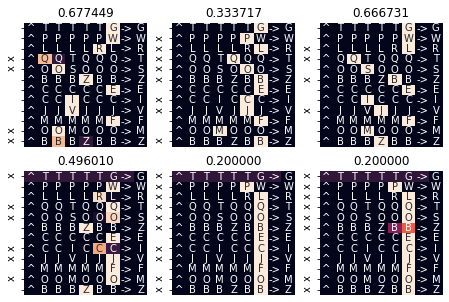

In [4950]:
front_chains = [
    [[(11, 8), create_mask(ans_positions, tgt_positions)]],
    [[(9, 9), create_mask(tgt_positions + 1, tgt_positions)], [(10, 1), create_mask(ans_positions, tgt_positions + 1)]],
]
rear_chains = [
    [[(12, 18), create_mask(arrow_positions, ans_positions)], [(13, 2), None]],
    [[(12, 18), create_mask(arrow_positions, ans_positions, accum=True)], [(13, 2), None]],
]

sum_a = {i: 0 for i in range(len(rear_chains))}
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for j, front_chain in enumerate(front_chains):
    l0 = front_chain[0][0][0]
    h = h0 = get_ln(l0)(hidden_states[l0])
    for (layer, head), mask in front_chain:
#         attn = globalize(attentions[layer])[:, head] #if layer in [9] else mask
        attn = mask
        wvo = get_combined_w(layer, head)
        h = attn.matmul(h.matmul(wvo))
    for i, rear_chain in enumerate(rear_chains):
        (layer, head), mask = rear_chain[0]
        attn = mask
        wvo = get_combined_w(layer, head)
        q = attn.matmul(h.matmul(wvo))
        wqk = get_combined_w(*rear_chain[-1][0], qk=True)
        q = q.matmul(wqk)[:, arrow_positions].unsqueeze(2)
        k = h0.view(h0.size(0), nrows, ncols + 3, hidden_size)
        a = q.matmul(k.transpose(-1, -2)).squeeze(2) / 1
        a[:, :, [-1]] = -1e9
        sum_a[i] = sum_a[i] + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j], title='%f' % loss.item())

for i in range(len(rear_chains)):
    a = sum_a[i]
    a = a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2], title='%f' % loss.item())

In [4602]:
_sattn, __sattn = torch.zeros(1, seq_len, seq_len), torch.zeros(1, seq_len, seq_len)
for i in range(0, nrows):
    _sattn[:, arrow_positions[i], tgt_positions[i]] = 1
    __sattn[:, arrow_positions[i], tgt_positions[:i]] = 1 / i if i > 0 else 0

0.157 0.497 0.250 
0.100 0.809 0.264 


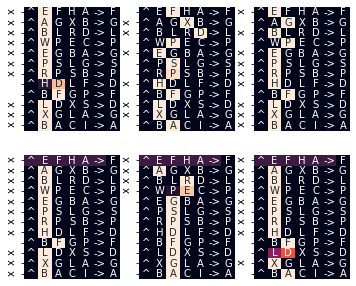

In [4605]:
ww0 = torch.eye(hidden_size)
# layer = 9; ln = blocks[layer].ln_1
# h0 = key0 = ln(hidden_states[layer])
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for i, attn in enumerate([_sattn, __sattn]):
    sum_a = 0
    for j, (w, layer) in enumerate([(ww, 11), (ww2, 9)]):
        ln = blocks[layer].ln_1
        h0 = key0 = ln(hidden_states[layer])
        query = attn.matmul(h0)[:, arrow_positions].matmul(w).unsqueeze(2)
        key = key0.view(key0.size(0), nrows, ncols + 3, hidden_size)
        a = (query * key).sum(-1) / 1
        a[:, :, [-1]] = -1e9
        sum_a = sum_a + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j])
    a = sum_a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2])
    print()

In [3719]:
aw = ww * ww.grad

In [3721]:
aw.norm(dim=0).topk(10)

torch.return_types.topk(
values=tensor([0.0037, 0.0029, 0.0027, 0.0025, 0.0023, 0.0023, 0.0018, 0.0016, 0.0016,
        0.0016], grad_fn=<TopkBackward>),
indices=tensor([  88,  586, 2484,  408, 1782,  578, 1781, 1019,  405, 1761]))

In [4962]:
head_outputs[9][0, :, ans_positions].norm(dim=-1).mean(-1).topk(10)

torch.return_types.topk(
values=tensor([12.2424, 11.6219, 11.3335, 10.7489,  9.3170,  9.2139,  8.5213,  7.5385,
         6.7957,  6.3538]),
indices=tensor([ 9, 19, 11,  7, 14,  6,  4, 10,  0,  8]))

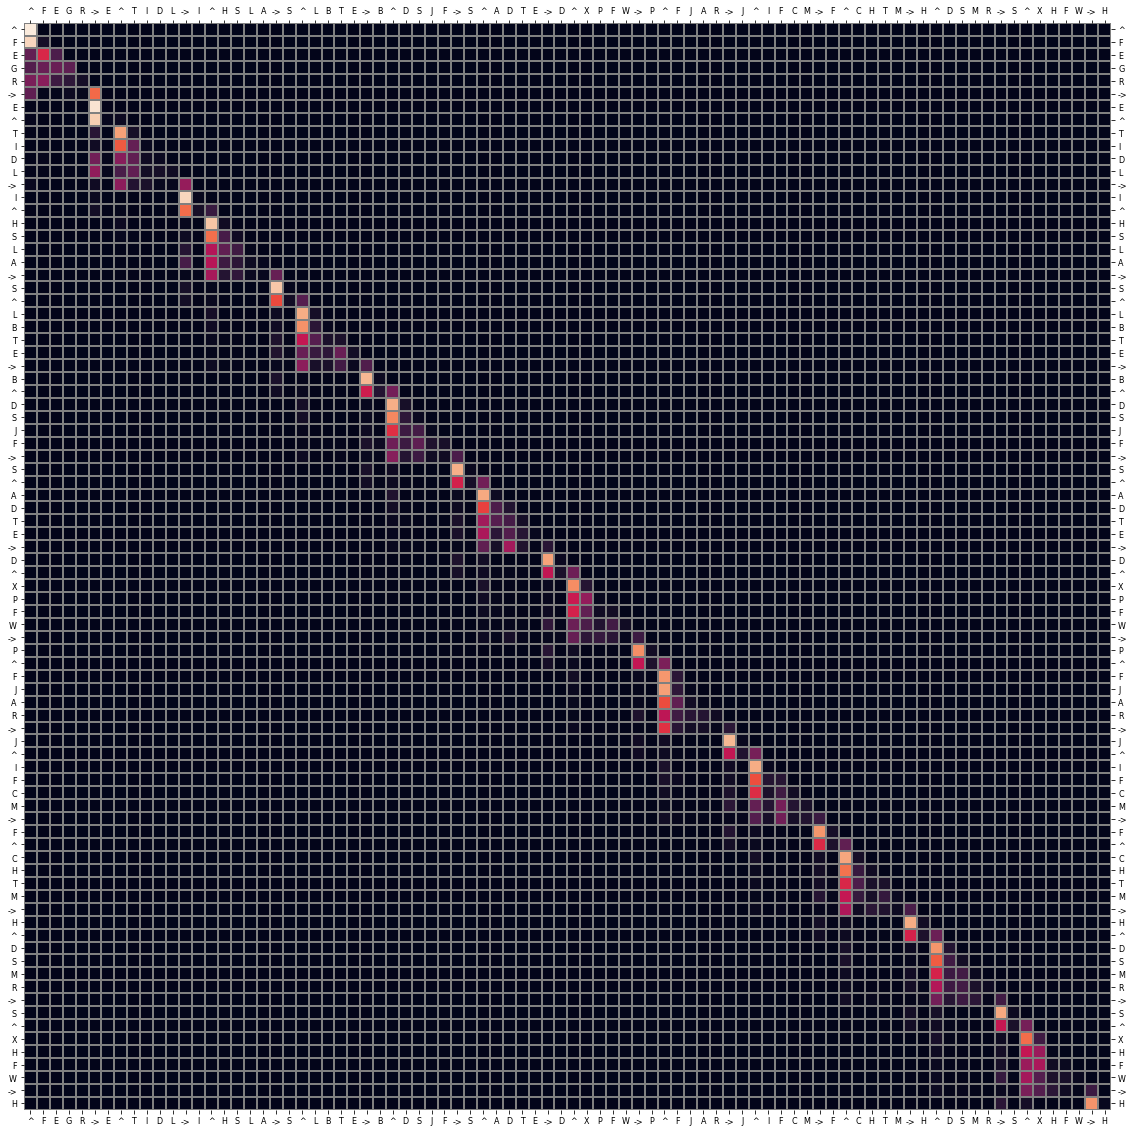

In [5037]:
plot_attn(globalize(attentions[9])[0, 6], figsize=(20, 20))

In [3360]:
a0 = head_outputs[9][0, 11, ans_positions]
a1 = head_outputs[11][0, 8, ans_positions]

In [3362]:
a0 = attrs['head_output'][9, 11, ans_positions]
a1 = attrs['head_output'][11, 8, ans_positions]

In [3363]:
cos = nn.CosineSimilarity(dim=1)
cos(a0, a1)

tensor([0.0226, 0.1145, 0.0712, 0.1595, 0.0533, 0.0150, 0.1125, 0.1410, 0.0172,
        0.0142, 0.0040, 0.0719])

In [3336]:
attr = attrs['attn_output'].sum(-1)
attr = attr / attr.view(attr.size(0), -1).norm(dim=1)[:, None]

<AxesSubplot:>

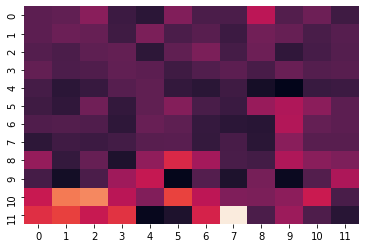

In [3337]:
sns.heatmap(numpy(attr[:, ans_positions]), cbar=False)

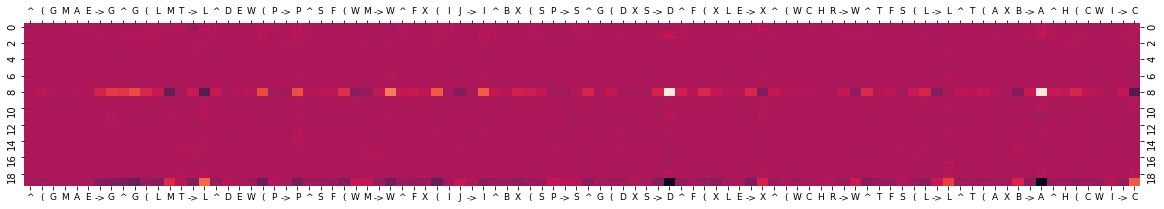

In [3887]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attrs['head_output'].sum(-1)[10]), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

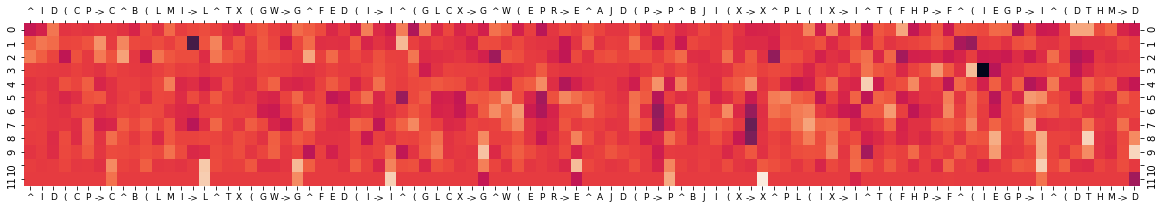

In [3303]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attr), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

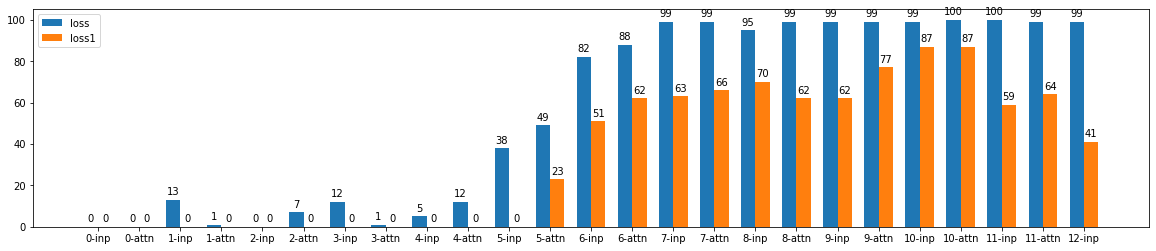

In [616]:
ffn_w = 0
results = []
for i in range(0, layer1 + 1):
    h1 = hidden_states[i] - hidden_states[0]*1
    residual = None #or hidden_states[layer1][:, arrow_positions]
    losses = [tgt_attn_loss(h1, attn, residual=residual, ffn_w=ffn_w) for attn in [_attn1, attn1]]
    results.append(('%d-inp' % i, losses[0], losses[1]))
    if i < layer1:
        losses = [tgt_attn_loss(h1 + attn_outputs[i], attn, residual=residual, ffn_w=ffn_w) 
                  for attn in [_attn1, attn1]]
        results.append(('%d-attn' % i, losses[0], losses[1]))
plot_tgt_attn_losses(*zip(*results))

10 tensor(0.2207, grad_fn=<MeanBackward0>)


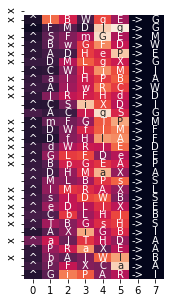

In [2149]:
a = []
tgt_h = hidden_states[layer0][0, tgt_positions]
h0 = hidden_states[layer0].view(nrows, ncols + 3, hidden_size)
for i in range(nrows):
    q = tgt_h[0:i].mean(dim=0)
    q = ln2(q).matmul(wq2.t())
    k = ln2(h0[i]).matmul(wq2.t())
#     attn1 = globalize(attentions[layer1]) * head_mask
#     attn_output1 = torch.matmul(attn1, _head_output1).sum(1)
#     q = ln2(attn_output1[:, arrow_positions[i]]).matmul(wq2.t())
#     q = ln2(_attn_output1[:, ans_positions][:, i:i+1].mean(1)).matmul(wq2.t())
#     k = key[i]
    a.append((q * k).sum(-1).unsqueeze(0))  # == torch.matmul(q, k.t())

a = torch.cat(a)
a[:, -2:] = -1000000
a = a.softmax(-1)
plot_tgt_attn(a)

In [3153]:
layer1, head1 = 12, 18
layer0, head0 = 11, 8
layer2, head2 = 13, 2  #17-4 for A[B]C->B,A*BC->B, 13-5 for reverse set diff
self0, self1, self2 = get_attn_module(blocks[layer0]), get_attn_module(blocks[layer1]), get_attn_module(blocks[layer2])

h_mask = torch.ones(hidden_size)
h_mask[top_i[0]] = 0

ln0, ln1, ln2 = blocks[layer0].ln_1, blocks[layer1].ln_1, blocks[layer2].ln_1
# mean, var = forward(blocks[layer2], 'ln1_mean_var')

wq0, wk0, wv0, wo0 = get_head_weights(layer0, head0)
wq1, wk1, wv1, wo1 = get_head_weights(layer1, head1)
wq2, wk2, wv2, wo2 = get_head_weights(layer2, head2)

In [3396]:
attn_output0, ffn_output0 = forward(blocks[layer0], ['attn_output', 'ffn_output'], exit_module=blocks[layer0],
                                    extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])
head_output0 = forward(get_attn_module(blocks[layer0]), 'head_output', exit_module=blocks[layer0],
                        extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])

10


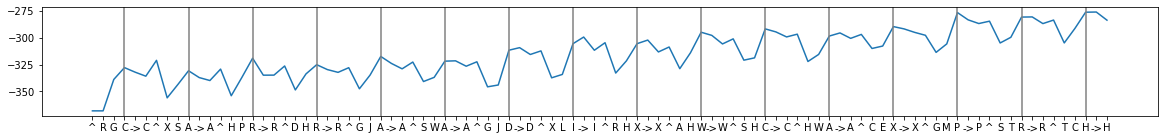

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 tensor(1.0000, grad_fn=<MeanBackward0>)


In [1202]:
## h1 = ln1(hidden_states[10]*0 + attn_output0 * 1 + ffn_output0 * 1)
h1 = ln1(hidden_states[layer0]*1 + attn_outputs[10]*1 + ffn_outputs[10] * 1 + attn_outputs[11] * 1 + ffn_outputs[11] * 1)

self1.head_output, self1.attn_output = None, None
self1.w = attentions[layer1]
try: _ = self1(h1, attention_mask=attention_masks[layer1])
finally:
    head_output1, attn_output1 = getdelattr(self1, 'head_output'), getdelattr(self1, 'attn_output')
    try_delattr(self1, 'w')

query = get_query(self2, ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*0))
# query = get_query(self2, ln2(head_output1[:, [16, 18]].sum(1)))
# query = get_query((self2, head_outputs[layer1][:, head1]))
# query = get_query(self2, attn_hidden_states[layer2])
for layer in [layer0]:#range(layer2 + 1):
    key2 = get_key(self2, ln2(hidden_states[layer]))
#     key2 = get_key(self2, ln2(attn_outputs[9]))
    logits = (query * key2).sum(dim=-1)
    print(layer)
    _ = test(None, None, logits=logits, always_show=True)

In [73]:
emb = all_embs[task_name][key]
emb_attr = all_attrs[task_name][key + str(int(pred_attn))]

In [2881]:
layer0 = 10
# layer, head = 10, 8  # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 2  # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [483]:
positions = tgt_positions[1:]
offsets = [torch.zeros_like(positions) - 1, torch.zeros_like(positions), torch.zeros_like(positions) + 1]
labels = numpy(torch.cat(offsets))
for layer in range(layer2):
    for head in range(H):
        emb = numpy(torch.cat([attn_outs[layer][0, head, positions + offset] for offset in offsets]))
#         emb = numpy(torch.cat([head_outputs[layer][0, head, positions + offset] for offset in offsets]))
        head_output = head_outputs[layer][:, head]
        if cluster(emb, labels)[0]:# and test(head_output, always_show=False) is not None:
#         if test(head_output, always_show=False) is not None:
            visualize_by_pca(emb, labels)
#             attn = globalize(attentions[layer])[0, head]
#             plot_attn(attn)
            print(layer, head)

(tensor([0.0174, 0.0392, 0.0546, 0.0641, 0.0408, 0.2807, 0.1289, 0.1209, 0.0977],
        grad_fn=<IndexBackward>),
 tensor(0.8444, grad_fn=<SumBackward0>))

(tensor([0.6571, 0.1062, 0.3671, 0.5548, 0.2617, 0.7426, 0.6988, 0.5396, 0.8236,
         0.6873], grad_fn=<SelectBackward>),
 tensor(0.5439, grad_fn=<MeanBackward0>))

(tensor([1.1355e-16, 3.7752e-13, 7.8185e-12, 6.1335e-10, 5.1372e-08, 3.3332e-06,
         3.1391e-04, 5.4327e-03, 1.5451e-01, 5.4892e-01],
        grad_fn=<IndexBackward>),
 tensor(0.0709, grad_fn=<MeanBackward0>))

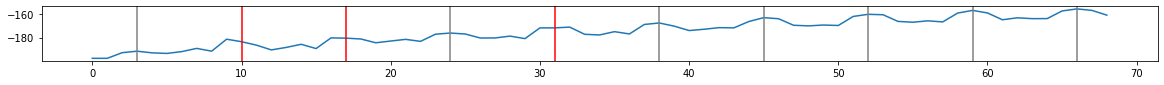

True

In [2023]:
layer0, head0 = 10, 1 #11-14  10-1
h_mask2 = torch.ones(hidden_size)
h_mask2[top_i[:]] = 0

attn_mask = torch.ones(H, seq_len, hidden_size // H)
# attn_mask[:, :] = 0
# attn_mask[8, :] = .1
m = get_attn_module(blocks[layer2])
outputs = forward(get_attn_module(blocks[layer0]), 'attn_mask', attn_mask, exit_module=blocks[layer2],
                 extra_tuples=[(m, 'return_attn_logits', True), #(m, 'hidden_states_mask', h_mask2),
#                                (get_attn_module(blocks[10]), 'hidden_states_mask', h_mask2),
                               (get_attn_module(blocks[layer1]), 'w', attentions[layer1])
                              ])

probs0 = outputs.attentions[layer1][0, head1, src, ans_positions[:-1]]
probs0, probs0.sum()
logits = globalize(outputs.attentions[layer2])[0, head2, src, : src + 1]
probs = logits[cand_positions].view(-1, n_candidates).softmax(-1)[:, task_name2idx[task_name]]
probs, probs.mean()
probs = logits.softmax(-1)[tgt_positions]
probs, probs.mean()
test(None, None, logits=logits)

tensor([[0.0066, 0.0076, 0.1356, 0.0835, 0.2636, 0.0631, 0.2177]],
       device='cuda:2')
tensor([0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
       device='cuda:2')
{'44 a': 0.3398, '42 ^': 0.2043, '43 Y': 0.1879, '38 I': 0.0659, '41 v': 0.0539}


{'Ġa': 0.3382, 'Ġv': 0.2697, 'ĠY': 0.0545, 'Ġu': 0.042, 'Ġy': 0.0365}

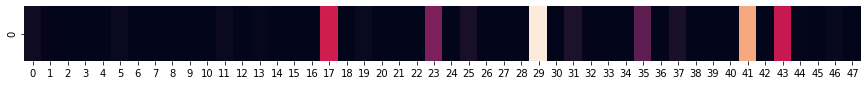

In [261]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [209]:
attn_grad[0, head - 2].mean()

tensor(0.0001, device='cuda:2')

In [169]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

torch.Size([1, 20, 72, 72])

torch.Size([10, 20, 72, 72])

tensor(6.2585e-05, device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

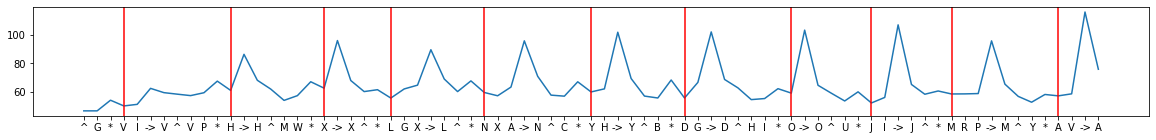

[0.017 0.002 0.011 0.    0.    0.001 0.    0.044 0.    0.088 0.13 ] 
 tensor(0.0266, grad_fn=<MeanBackward0>)


In [3504]:
qh = ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*1)[:, src:src+1]
kh = attn_hidden_states[layer2]
# kh = ln2(attn_outputs[9])
logits = (qh * kh).sum(dim=-1).squeeze(0)
_ = test(None, None, logits=logits, always_show=True)

In [11]:
texts = {
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed, but GPT-3 can with low prob
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K
K O Q, O Q -> K
K O N, K N -> O
R U P, R P -> U
X C J, X C -> J
B G V, G V -> B
H V L, H V -> L
J K M, J M -> K
N W K, W K -> N
F B D, F B -> D''',
    'find majority': '''
n d d -> d
f f d -> f
e b e -> e
s q s -> s
d d o -> d
c e e -> e
g t g -> g
i i w -> i''', # basically failed
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed, GPT-3 failed, too
    'find special2': '''
n d d d -> n
f f f d -> d
e b e e -> b
s s q s -> q
d d d o -> o
e c e e -> c
g g g t -> t
w i i i -> w''',  # failed, but GPT-3 can
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J K M -> K
A W K, U W K -> U
F B Y, F B D -> D''',
    'reverse set diff': '''
O Q, K O Q -> K
K N, K O N -> O
R P, R U P -> U
X C, X C J -> J
G V, B G V -> B
H V, H V L -> L
J M, J K M -> K
W K, N W K -> N
F B, F B D -> D''',
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'find next': '''
W S D L, S -> D
F M W Q, F -> M
T W A V, A -> V
U V N M, N -> M
S D N O, S -> D
A S B T, S -> B
H W L Z, H -> W
C L J O, J -> O
T B A E, B -> A
L G C K, L -> G
G B S O, G -> B
K Y F O, F -> O
V Q U S, V -> Q
S E Y P, Y -> P
X D A U, A -> U
T L M N, L -> M
U O Y I, O -> Y''',  # failed, GPT-3 failed too
    'antonym': '''
big -> small
low -> high
fast -> slow
dark -> light
long -> short''',
}

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [258]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

(tensor(-0.7157, device='cuda:2'), tensor(17.1320, device='cuda:2'))

2.3035 0.7521 2.545 tensor(-0.7262, device='cuda:2') tensor(17.2453, device='cuda:2')
2.545 0.7547 2.7227 tensor(-0.7361, device='cuda:2') tensor(17.7049, device='cuda:2')
2.7227 0.7046 2.9372 tensor(-0.7366, device='cuda:2') tensor(17.8712, device='cuda:2')
2.9372 0.8032 3.1048 tensor(-0.7600, device='cuda:2') tensor(18.7369, device='cuda:2')
3.1048 0.8814 3.2894 tensor(-0.7694, device='cuda:2') tensor(18.9570, device='cuda:2')
3.2894 0.8759 3.2595 tensor(-0.7893, device='cuda:2') tensor(19.1697, device='cuda:2')


In [257]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

torch.return_types.topk(
values=tensor([0.4904, 0.3162, 0.0501, 0.0432, 0.0416], device='cuda:2'),
indices=tensor([42, 43, 36, 44, 46], device='cuda:2'))

In [326]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'44 E': 0.7865, '43 V': 0.1431, '38 K': 0.0355, '45 H': 0.0323, '37 A': 0.001}

{'ĠE': 0.8562, 'ĠH': 0.1216, 'ĠV': 0.0133, 'ĠD': 0.0009, 'ĠI': 0.0007}

{'28 ->': 0.6616,
 '40 ->': 0.3003,
 '22 ->': 0.0244,
 '34 ->': 0.013,
 '16 ->': 0.0003}

{'ĠT': 0.2914, 'ĠC': 0.1015, 'ĠL': 0.0839, 'ĠY': 0.0793, 'ĠE': 0.0643}

In [70]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

[(17, 1, 1.08707237),
 (19, 21, 1.00648546),
 (21, 13, 0.78149551),
 (17, 10, 0.68284625),
 (17, 15, 0.63359404),
 (18, 18, 0.62241864),
 (22, 15, 0.52263898),
 (20, 5, 0.45230082),
 (19, 17, 0.36873266),
 (21, 4, 0.33636701)]

In [26]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

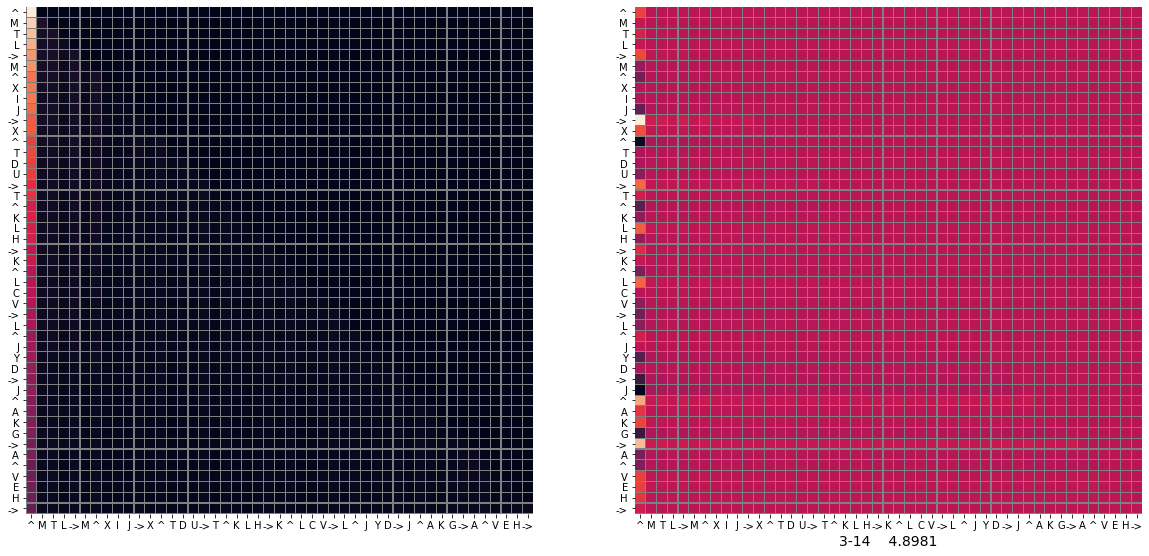

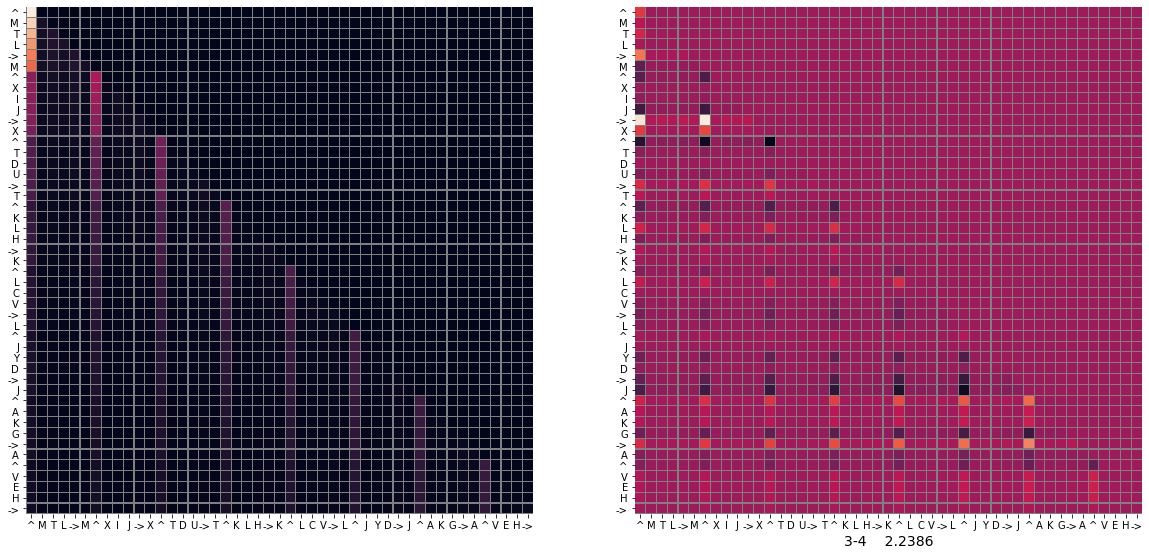

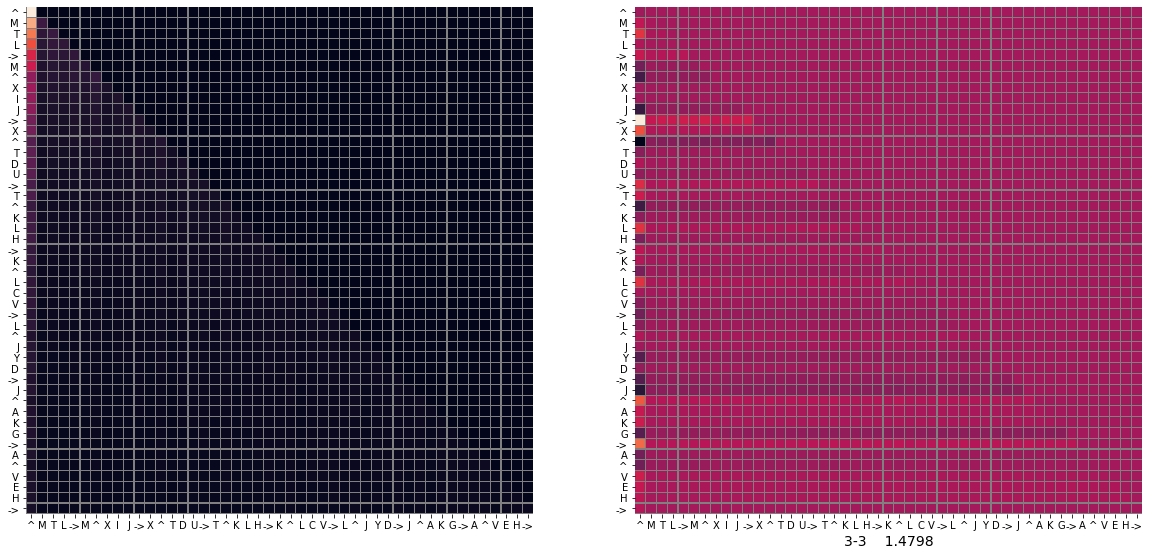

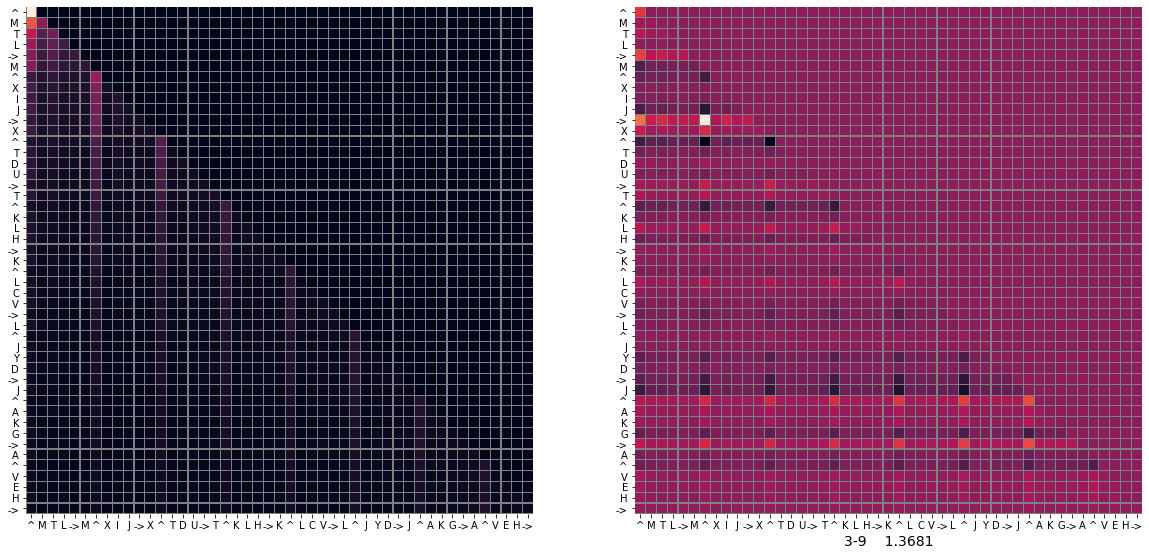

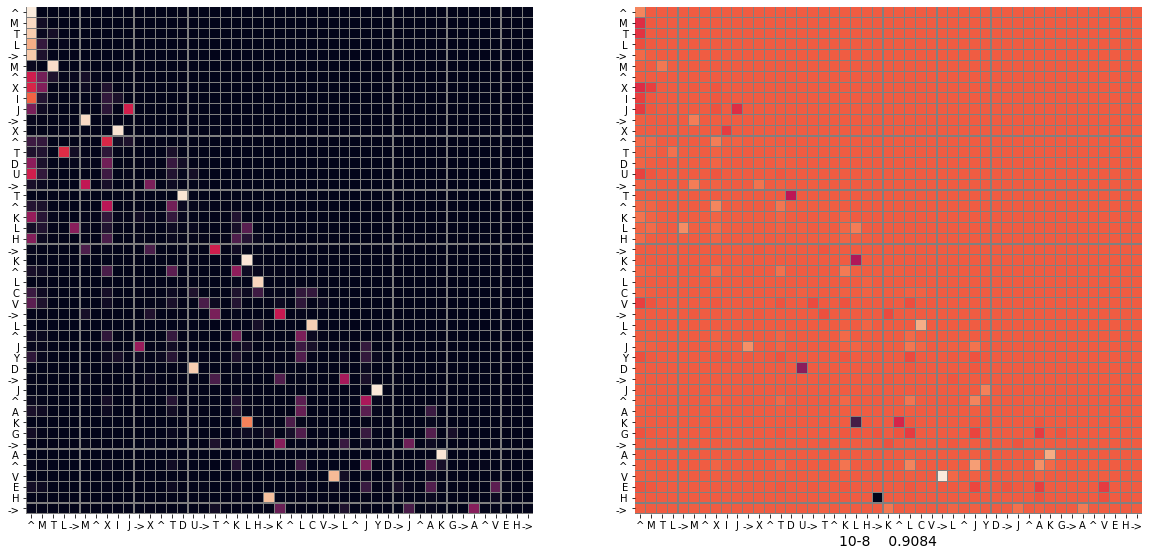

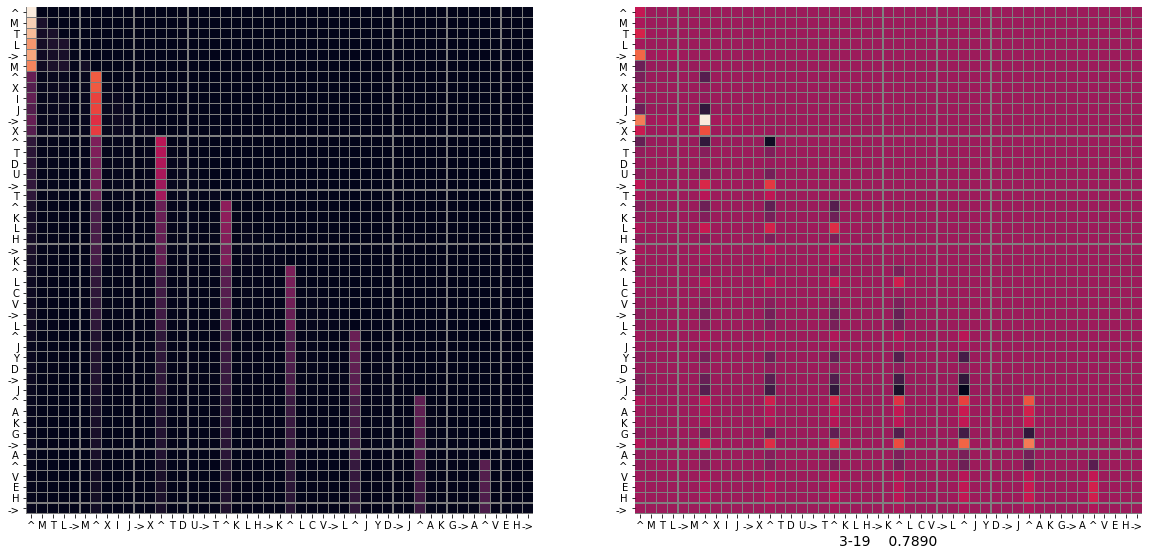

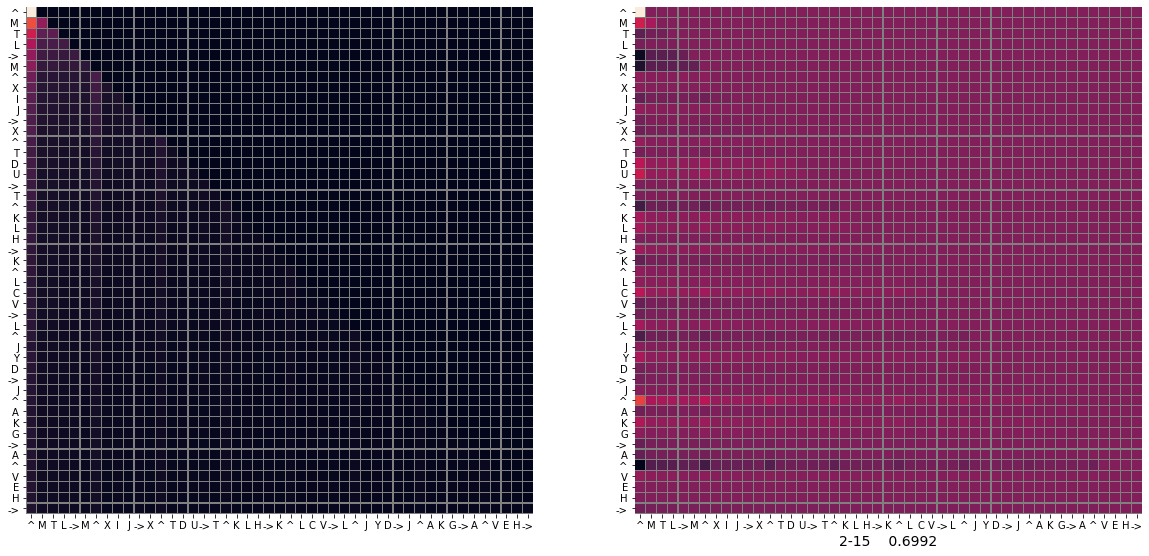

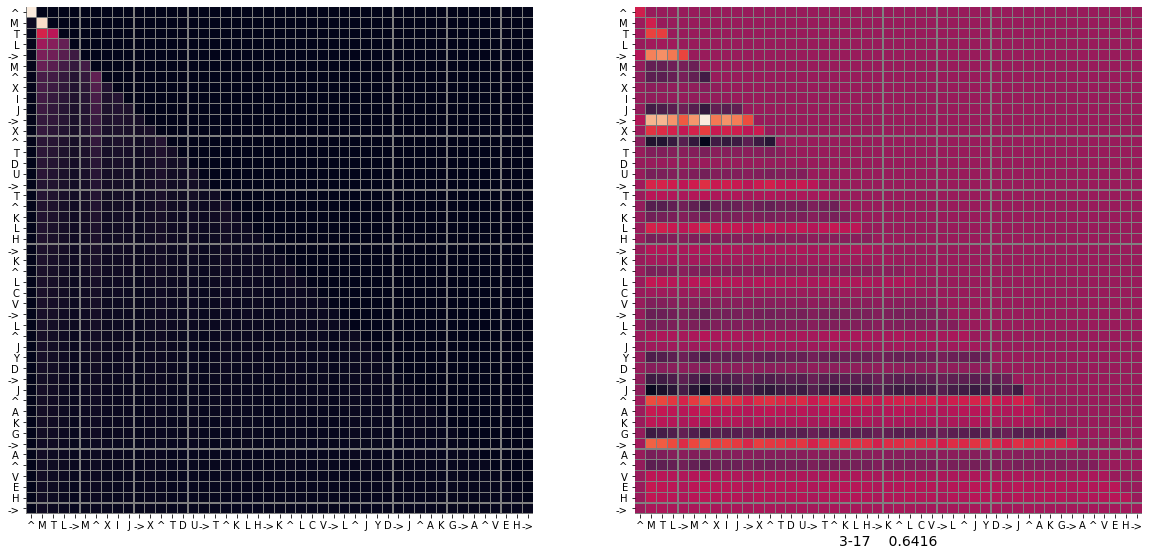

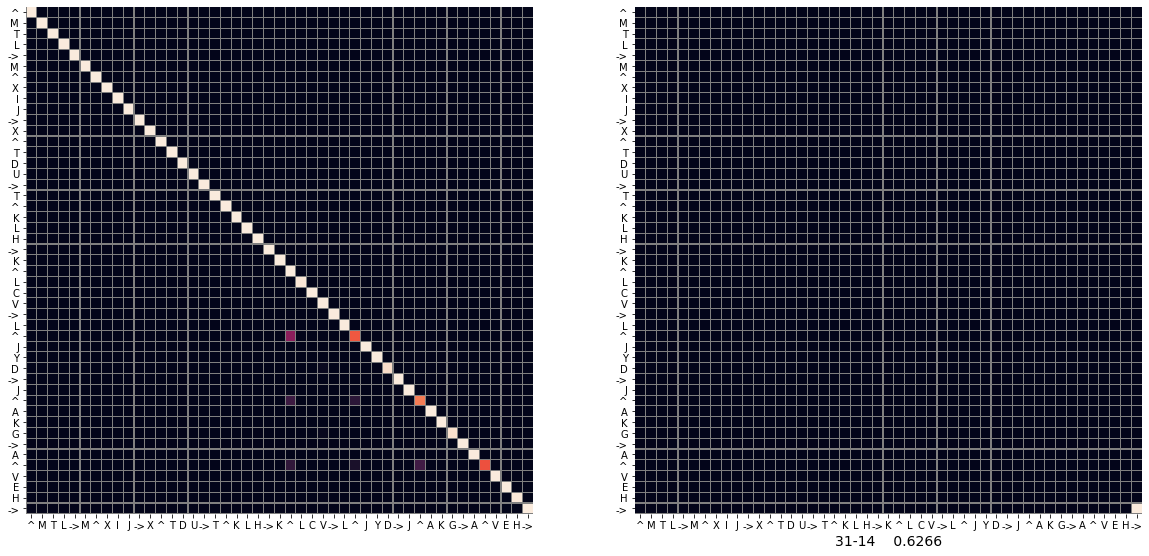

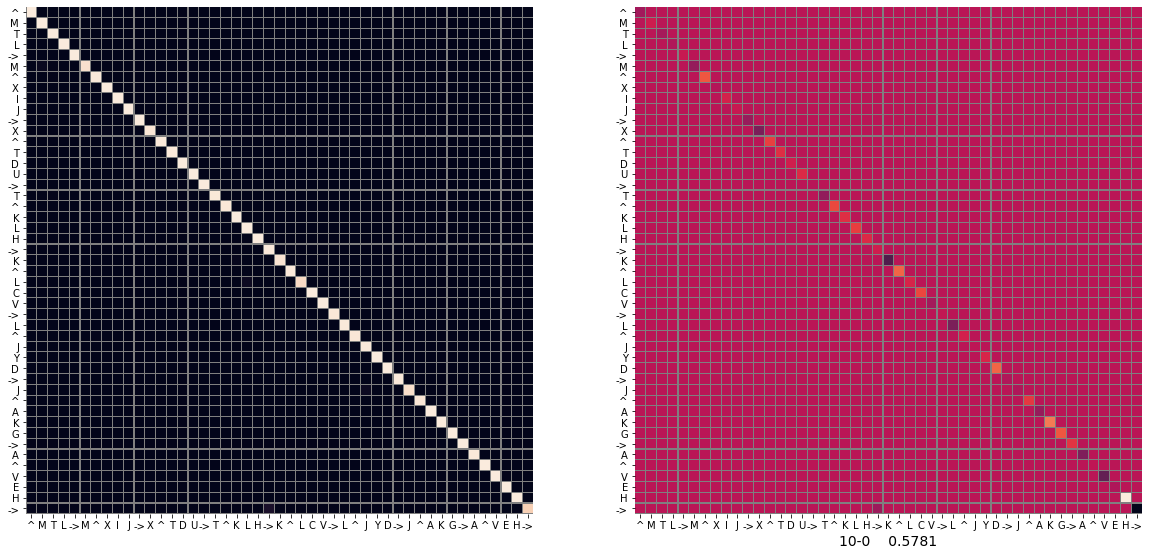

In [259]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

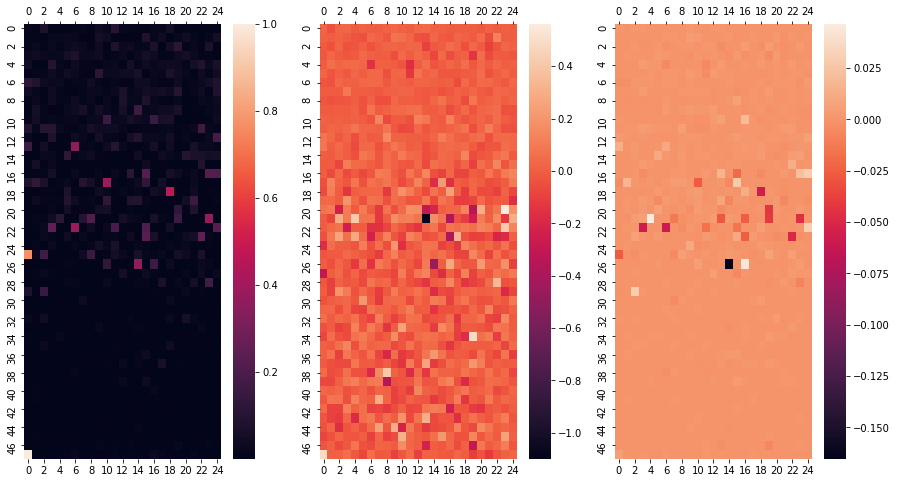

In [555]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [383]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [132]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '▁', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1>.</s>
['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1> welcome.</s>


In [342]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]